<a href="https://colab.research.google.com/github/GielHagenbeek/WaterhyacinthsSentinel2/blob/main/No_Filte_of_GD_Revised_Water_Hyacinth_classification_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Water Hyacinth classification tool:
Copyright 2020 Niels Janssens

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## 1. Install all required modules

In [ ]:
# install required modules
!pip install pandas
!pip install geopandas
!pip install rasterio
!pip install sentinelhub
!pip install eo-learn
!pip install gdal
!pip install cartopy
!pip install shapely
!pip install fiona
!pip install geos
!pip install proj
!pip install scikit-image
!pip install geoviews'
!pip install lightgbm
!pip install s2cloudless #import cloudless model - clean perhaps
!pip install eo-learn graphviz

!apt-get install -qq libgdal-dev libproj-dev
!pip install cartopy
!pip install eo-learn-visualization[FULL] #clean perhaps

!pip install numpy
!pip install pyepsg
!pip install -U scikit-image



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.3/242.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1

## 2. Import required models

In [ ]:
# import required modules
# Built-in modules
import pickle
import os
import datetime
import itertools
from enum import Enum
from functools import partial
from datetime import timedelta
from datetime import datetime
import scipy.stats as stats
import copy

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from numba import jit
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon as Polygon1
from tqdm import tqdm_notebook as tqdm
import shapely
import pyepsg
from rasterio.plot import reshape_as_raster, reshape_as_image
from google.colab import drive

# Machine learning
import lightgbm as lgb
import joblib
from sklearn.naive_bayes import GaussianNB
import sklearn.model_selection
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from sentinelhub import (
    CRS,
    BBox,
    BBoxSplitter,
    CustomGridSplitter,
    DataCollection,
    MimeType,
    MosaickingOrder,
    OsmSplitter,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    TileSplitter,
    UtmGridSplitter,
    UtmZoneSplitter,
    read_data,
)
from eolearn.core import SaveTask, LoadTask, FeatureType, EOWorkflow, EOTask, OverwritePermission, EOExecutor, EOPatch,EONode, OutputTask, AddFeatureTask
from eolearn.io import SentinelHubInputTask, SentinelHubDemTask, SentinelHubEvalscriptTask, get_available_timestamps, ExportToTiffTask
from eolearn.mask import MaskFeatureTask, JoinMasksTask
from eolearn.mask.extra.cloud_mask import CloudMaskTask #Add cloud mask task
from eolearn.geometry import VectorToRasterTask, ErosionTask #PointSamplingTask replaced?
from eolearn.features import SimpleFilterTask
import eolearn.features.extra.interpolation
from eolearn.features.extra.interpolation import LinearInterpolationTask
import eolearn.visualization
import skimage.transform
from skimage.filters import threshold_otsu, sobel
from skimage.morphology import disk, erosion, dilation, opening, closing, white_tophat

/usr/lib/python3/dist-packages/blinker/base.py:96: SyntaxWarning: invalid escape sequence '\*'
  `sender=` as a single positional argument and any \*\*kwargs that
/usr/lib/python3/dist-packages/blinker/base.py:174: SyntaxWarning: invalid escape sequence '\*'
  `sender=` as a single positional argument and any \*\*kwargs that
/usr/lib/python3/dist-packages/blinker/base.py:242: SyntaxWarning: invalid escape sequence '\*'
  """Emit this signal on behalf of *sender*, passing on \*\*kwargs.
/usr/local/lib/python3.12/dist-packages/eolearn/__init__.py:13: UserWarning: You are currently using an outdated installation of `eo-learn` for submodules ['visualization']. You can find instructions on how to install `eo-learn` correctly at https://github.com/sentinel-hub/eo-learn/issues/733.
  warnings.warn(


## 3. Configure Sentinelhub settings & connect to Google Drive folder

### 3.1. Connect to Sentinelhub

In [ ]:
"""insert sentinelhub configuration settings here. Create a Sentinel-2 configuration on
   https://apps.sentinel-hub.com/dashboard/#/ and replace the empty "" instance_id,
   sh_client_id and sh_client_secret by your custom strings"""

!sentinelhub.config --instance_id ""
!sentinelhub.config --sh_client_id ""
!sentinelhub.config --sh_client_secret ""
!sentinelhub.config --max_download_attempts 15
!sentinelhub.config --download_sleep_time 300
!sentinelhub.config --max_wfs_records_per_query 10
!sentinelhub.config --max_opensearch_records_per_query 10
!sentinelhub.config --show


The value of parameter `instance_id` was updated to 'a883f502-1951-4544-8c3d-f7ae6f874e1c'
The value of parameter `sh_client_id` was updated to '948b3ab9-7cbe-4a1e-a56f-c7d029a2359e'
The value of parameter `sh_client_secret` was updated to 'FZ5NvjFqVMZbh5Q11FoY1ObY9rlSFEBg'
The value of parameter `max_download_attempts` was updated to 15
The value of parameter `download_sleep_time` was updated to 300
The value of parameter `max_wfs_records_per_query` was updated to 10
The value of parameter `max_opensearch_records_per_query` was updated to 10
{
  "instance_id": "a883f502-1951-4544-8c3d-f7ae6f874e1c",
  "sh_client_id": "948b3ab9-7cbe-4a1e-a56f-c7d029a2359e",
  "sh_client_secret": "FZ5NvjFqVMZbh5Q11FoY1ObY9rlSFEBg",
  "sh_base_url": "https://services.sentinel-hub.com",
  "sh_auth_base_url": null,
  "sh_token_url": "https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## 4. Test and train manually labeled Water Hyacinth and Water for supervised
classification pixels

In [ ]:
%matplotlib inline

# read manually labeled pixel data that can be used as input for the Naive Bayes classifier
data = pd.read_csv('./drive/My Drive/SentinelModel/input_data/points_all.csv')
np.take(data,np.random.permutation(data.shape[0]),axis=0)

# split testing and training data using the sklearn module
testing_data, training_data = sklearn.model_selection.train_test_split(data)

# convert classes to an integer
training_classes_int = np.zeros(training_data["Label"].values.shape, dtype=np.uint8)
training_classes_int[training_data["Label"].values == "WH"] = 2
training_classes_int[training_data["Label"].values == "W"] = 1

# convert classes to an integer
testing_classes_int = np.zeros(testing_data["Label"].values.shape, dtype=np.uint8)
testing_classes_int[testing_data["Label"].values == "WH"]   = 2
testing_classes_int[testing_data["Label"].values == "W"] = 1

# convert to one numpy array
training_array = np.array([training_classes_int, training_data["ndvi"].values, training_data["fai"].values,
                              training_data["B2"].values, training_data["B3"].values, training_data["B12"].values])

# flip around
training_array = training_array.transpose()

# convert to one numpy array
testing_array = np.array([testing_classes_int, testing_data["ndvi"].values, testing_data["fai"].values,
                             testing_data["B2"].values, testing_data["B3"].values, testing_data["B12"].values])

# flip around
testing_array = testing_array.transpose()

# train Gaussian Naive Bayes model
gnb = GaussianNB()
class_model = gnb.fit(training_array[:,1:], training_array[:,0])

# Check fit. Note as this uses exactly the same data as training doesn't represent accuracy.
# It does give a rough idea of how well model fits though
score = class_model.score(testing_array[:,1:], testing_array[:,0])
print("Classification fit using all data: {:.02}".format(score))


# predict classes by using the trained model
out_classes = class_model.predict(testing_array[:,1:])


# uncomment to save the model
joblib.dump(class_model, './model_SI_LULC.pkl')

Classification fit using all data: 0.96


['./model_SI_LULC.pkl']

In [ ]:
# group data by Label, rename the bands for visualisation purposes
mean_values = data.groupby('Label', as_index=False)[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']].mean()
std_values = data.groupby('Label', as_index=False)[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']].std()
mean_values.rename(columns={'B1': '442', 'B2': '492', 'B3': '559', 'B4': '665', 'B5': '704', 'B6': '740', 'B7': '780', 'B8': '833', 'B8A': '864', 'B9': '944', 'B11': '1612', 'B12': '2190'}, inplace=True)
std_values.rename(columns={'B1': '442', 'B2': '492', 'B3': '559', 'B4': '665', 'B5': '704', 'B6': '740', 'B7': '780', 'B8': '833', 'B8A': '864', 'B9': '944', 'B11': '1612', 'B12': '2190'}, inplace=True)

# transpose data
mean_values = mean_values.transpose()
mean_values = mean_values.reset_index(drop=False)

# grab the first row for the header
new_header = mean_values.iloc[0]

# take the data less the header row
mean_values = mean_values[1:]

# set the header row as the df header
mean_values.columns = new_header

# transpose data
std_values = std_values.transpose()
std_values = std_values.reset_index(drop=False)

# grab the first row for the header
new_header2 = std_values.iloc[0]
new_header2

# take the data less the header row
std_values = std_values[1:]
std_values.columns = new_header2

# calculate mean values for Water label
mean_values.W.values
mean_w = np.array(mean_values.W.values, dtype=float)

# calculate standard deviation values for Water label
std_values.W.values
st_w = np.array(std_values.W.values, dtype=float)

# calculate mean values for Water hyacinth label
mean_values.WH.values
mean_wh = np.array(mean_values.WH.values, dtype=float)

# calculate standard deviation values for Water hyacinth label
std_values.WH.values
st_wh = np.array(std_values.WH.values, dtype=float)

#Copy mean values
test1 = mean_values.copy()

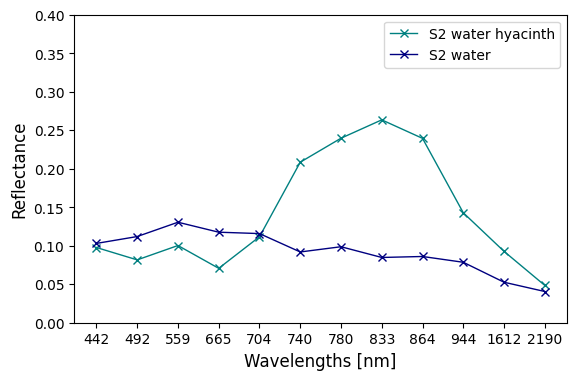

In [ ]:
# create figure visualizing the mean spectral signatures of water and water hyacinth labeled pixels
# set figure subplots & size
fig, axes = plt.subplots(ncols = 2, figsize=(14,4))
axes[0].plot(test1.Label, test1.WH, c = 'teal', linewidth = 1, markerfacecolor = 'teal', marker = 'x',markersize = 6)
axes[0].plot(test1.Label, test1.W, c = 'navy', linewidth = 1, markerfacecolor = 'navy', marker = 'x',markersize = 6)
axes[0].legend(['S2 water hyacinth', 'S2 water'], ncol=1, fontsize = 10)
axes[0].set_xlabel("Wavelengths [nm]", fontsize = 12)
axes[0].set_ylabel("Reflectance", fontsize = 12)
axes[0].set_ylim(0,0.4)
axes[1].set_visible(False)

# save figure to specified folder and plot figure
new_dir_path = './drive/My Drive/SentinelModel/figures'
os.makedirs(new_dir_path, exist_ok=True)  # The `exist_ok=True` argument ensures it doesn't throw an error if the directory already exists


plt.savefig('./drive/My Drive/SentinelModel/figures/spectral_signatures.png', bbox_inches = "tight")
plt.show()

/tmp/ipython-input-17-2673885998.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Label", y="ndvi",
/tmp/ipython-input-17-2673885998.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set(xticklabels=["Water", "Water hyacinth's"])
/tmp/ipython-input-17-2673885998.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x="Label", y="fai",
/tmp/ipython-input-17-2673885998.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set(xticklabels=["Water", "Water hyacinth's"])


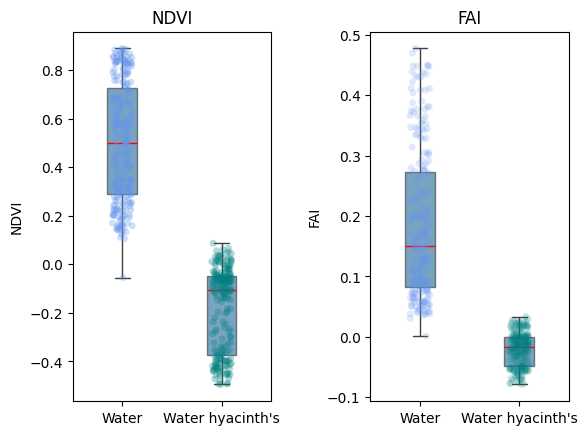

In [ ]:
# create figure visualizing the spectral signatures of water and water hyacinth labeled pixels
# set figure subplots & size
f, axes = plt.subplots(1, 2)
sns.set_style("ticks")

#create your own color array
my_colors = ["cornflowerblue", "teal"]
my_colors1 = ["cornflowerblue", "teal"]

# add color array to set_palette
sns.set_palette(my_colors)

# add boxplot of ndvi data
sns.boxplot(x="Label", y="ndvi",
data=testing_data, width=0.3, boxprops=dict(alpha=.65), medianprops=dict(color="red", alpha=1), ax=axes[0])

# add stripplot of ndvi data
sns.stripplot(x="Label", y="ndvi",
data=testing_data, alpha=0.3, palette = my_colors1, ax=axes[0])

# set ndvi labels
axes[0].set(xticklabels=["Water", "Water hyacinth's"])
axes[0].set_title('NDVI')
axes[0].set_ylabel('NDVI')
axes[0].set_xlabel('')

# add boxplot of fai data
ax = sns.boxplot(x="Label", y="fai",
data=testing_data, width=0.3, boxprops=dict(alpha=.65), medianprops=dict(color="red", alpha=1), ax=axes[1])

# add stripplot of fai data
ax = sns.stripplot(x="Label", y="fai",
data=testing_data, alpha=0.2, palette = my_colors1, ax=axes[1])

# set fai labels
axes[1].set(xticklabels=["Water", "Water hyacinth's"])
axes[1].set_title('FAI')
axes[1].set_ylabel('FAI')
axes[1].set_xlabel('')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.8)

# save figure to specified folder and plot figure
plt.savefig('./drive/My Drive/SentinelModel/figures/spectral_signatures_fai.png', bbox_inches = "tight")


## 5. Define area of interest
Load shapefile and create bounding boxes for parallel computing

   OBJECTID Name1 Name2 Name3              TYPE ISO_CC  SHAPE_Length  \
0         1                    Inland perennial     TH      1.466933   

   SHAPE_Area                                           geometry  
0    0.001678  POLYGON ((664395.894 1562843.553, 664388.868 1...  


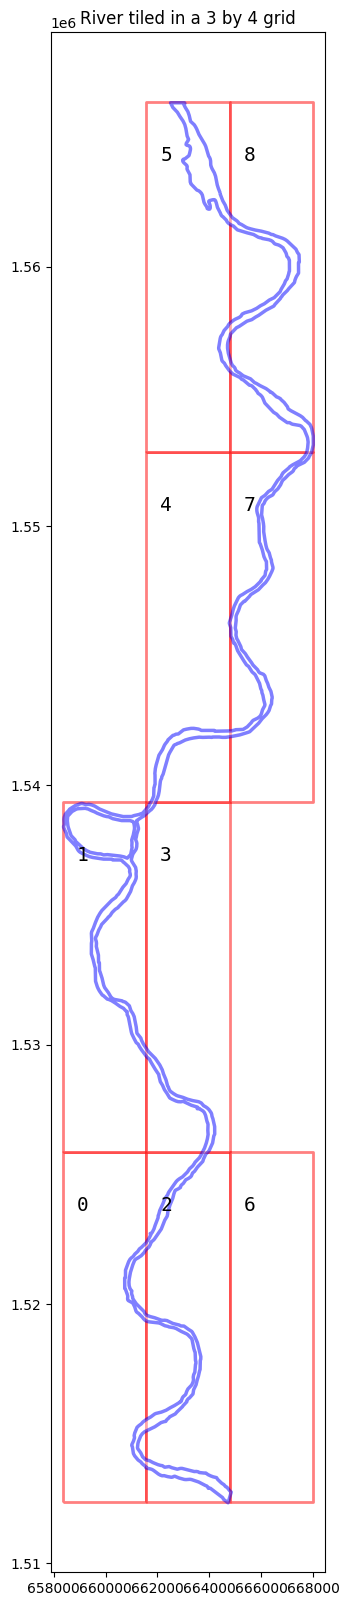

In [ ]:
# load geojson file, file can be found on github page
river = GeoDataFrame.from_file(os.path.join('./drive/My Drive/SentinelModel/input_data/CPRaoi_V01.json'))

# convert CRS to UTM_47N, based on our area of interest
river = river.to_crs(crs=CRS.UTM_47N.pyproj_crs())

# get the country's shape in polygon format & create a bounding box
river_shape = river.geometry.tolist()[-1]
minx, miny, maxx, maxy = river_shape.bounds
river_bbox = BBox([minx, miny, maxx, maxy], crs=CRS.UTM_47N.pyproj_crs())
river_bbox = river_bbox.geometry - river_shape
print(river)
# split river into multiple smaller bounding boxes
bbox_splitter = BBoxSplitter([river_shape], CRS.UTM_47N.pyproj_crs(), (3,4))
bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# create patchIDs that can be used for parallel computing
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    patchIDs.append(idx)

# prepare info of selected EOPatches
geometry = [Polygon1(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]

# create geodataframe using the idxs_x and idxs_y
gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y},
                       crs=CRS.UTM_47N.pyproj_crs(),
                       geometry=geometry)

# create polygon and set fontdict that can be used for figure
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 14}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/3

# figure with bboxes and river shapefile plotted
fig, ax = plt.subplots(figsize=(20,20))
gdf.plot(ax=ax, facecolor='w', edgecolor='r', alpha=0.5, linewidth=2)
river.plot(ax=ax, facecolor='w', edgecolor='b', alpha=0.5, linewidth=2.5)
ax.set_title('River tiled in a 3 by 4 grid');

# add annotiation text figure
for idx in gdf.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    centroid, = list(gdf.geometry[idx].centroid.coords)
    ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(idx), fontdict=fontdict)

# save figure to specified folder and plot figure
plt.savefig('./drive/My Drive/SentinelModel/figures/area_of_interest_bboxes.jpg')

In [ ]:
# Export river shape
river.to_file('./drive/My Drive/SentinelModel/input_data/river_shape.geojson', driver='GeoJSON')

# Export river grid tiles (gdf)
gdf.to_file('./drive/My Drive/SentinelModel/input_data/river_grid_tiles.geojson', driver='GeoJSON')


## 6. Create EO workflow to:
*   Download data
*   Create a cloud mask
*   Create a river mask
*   Add FAI, NDVI
*   Add spatial temporal features
*   Perform Naive bayes classification

### Set time interval and define nominal water

In [ ]:
#adapt time_interval according to period of interest
time_interval = ['2024-06-01', '2025-06-01'] # time interval for the SH request

In [ ]:
# create nominal water mask that can be used to extract pixel values that are actually located within the river boundaries
add_nominal_water = VectorToRasterTask(river, (FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), values=1,
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), raster_dtype=np.uint8)


### 6.1 EO Tasks to compute 'VALIDE_DATA' based on cloud masks and count the valid observations

In [ ]:
class SentinelHubValidData(EOTask):
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):

      # Count non-zero values across the time dimension
        valid_counts = np.count_nonzero(eopatch.mask[self.what], axis=0)

        # Add the result as a new timeless mask feature
        add_feature_task = AddFeatureTask((FeatureType.MASK_TIMELESS, self.name))
        eopatch = add_feature_task.execute(eopatch, valid_counts)

        return eopatch

class SentinelHubValidDataTask(EOTask):
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """

    def __init__(self, output_feature):
        self.output_feature = output_feature

    def execute(self, eopatch):
        eopatch[self.output_feature] = eopatch.mask["IS_DATA"].astype(bool) & (~eopatch.mask["CLM"].astype(bool))
        return eopatch


### 6.2 Create workflow and required classes

In [ ]:
#add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12)
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover
# detection is performed in the next step
# use sentinelhubinputtask function that retrieves the specified data for our area of interest
custom_script = ['B02', 'B03', 'B04', 'B06', 'B08', 'B11', 'B12']
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = custom_script,
    resolution=10,
    maxcc=0.8,
    data_collection=DataCollection.SENTINEL2_L2A, #change DataSource to DataCollection
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP'),
                     (FeatureType.MASK, 'SCL')])

# class that defines if valid data fraction is above the specified threshold
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

# class that calculates ndvi on a pixel level
class NormalizedDifferenceIndex(EOTask):

    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        ndvi = (band_a - band_b) / (band_a  + band_b)

        #eopatch.add_feature(FeatureType.DATA, self.feature_name, ndvi[..., np.newaxis])
        #eopatch[FeatureType.DATA][self.feature_name] = ndvi[..., np.newaxis]
        add_feature_task = AddFeatureTask((FeatureType.DATA, self.feature_name))
        eopatch = add_feature_task.execute(eopatch, ndvi[..., np.newaxis])

        return eopatch

# class that calculates fai on a pixel level
class FloatingAlgaeIndex(EOTask):

    def __init__(self, feature_name, band_a, band_b, band_c, band_d, band_e, band_f, band_g):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_c_fetaure_name = band_c.split('/')[0]
        self.band_d_fetaure_name = band_d.split('/')[0]
        self.band_e_fetaure_name = band_e.split('/')[0]
        self.band_f_fetaure_name = band_f.split('/')[0]
        self.band_g_fetaure_name = band_g.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        self.band_c_fetaure_idx = int(band_c.split('/')[-1])
        self.band_d_fetaure_idx = int(band_d.split('/')[-1])
        self.band_e_fetaure_idx = int(band_e.split('/')[-1])
        self.band_f_fetaure_idx = int(band_f.split('/')[-1])
        self.band_g_fetaure_idx = int(band_g.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        band_c = eopatch.data[self.band_c_fetaure_name][..., self.band_c_fetaure_idx]
        band_d = eopatch.data[self.band_d_fetaure_name][..., self.band_d_fetaure_idx]
        band_e = eopatch.data[self.band_e_fetaure_name][..., self.band_e_fetaure_idx]
        band_f = eopatch.data[self.band_f_fetaure_name][..., self.band_f_fetaure_idx]
        band_g = eopatch.data[self.band_g_fetaure_name][..., self.band_g_fetaure_idx]


        fai = band_e - (((band_c * (842-1610)) + (band_g * (665-842)))/(665-1614))

        #eopatch.add_feature(FeatureType.DATA, self.feature_name, fai[..., np.newaxis])
        #eopatch[FeatureType.DATA][self.feature_name] = fai[..., np.newaxis]
        add_feature_task = AddFeatureTask((FeatureType.DATA, self.feature_name))
        eopatch = add_feature_task.execute(eopatch, fai[..., np.newaxis])


        return eopatch

# class that uses all the required input values on a pixel level and classifies WH & W using the trained Naive Bayes model
class WaterhyacinthClassification(EOTask):

    def __init__(self, feature_name, band_a, band_b, band_c, band_d, band_e, band_f, band_g):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_c_fetaure_name = band_c.split('/')[0]
        self.band_d_fetaure_name = band_d.split('/')[0]
        self.band_e_fetaure_name = band_e.split('/')[0]
        self.band_f_fetaure_name = band_f.split('/')[0]
        self.band_g_fetaure_name = band_g.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        self.band_c_fetaure_idx = int(band_c.split('/')[-1])
        self.band_d_fetaure_idx = int(band_d.split('/')[-1])
        self.band_e_fetaure_idx = int(band_e.split('/')[-1])
        self.band_f_fetaure_idx = int(band_f.split('/')[-1])
        self.band_g_fetaure_idx = int(band_g.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        band_c = eopatch.data[self.band_c_fetaure_name][..., self.band_c_fetaure_idx]
        band_d = eopatch.data[self.band_d_fetaure_name][..., self.band_d_fetaure_idx]
        band_e = eopatch.data[self.band_e_fetaure_name][..., self.band_e_fetaure_idx]
        band_f = eopatch.data[self.band_f_fetaure_name][..., self.band_f_fetaure_idx]
        band_g = eopatch.data[self.band_g_fetaure_name][..., self.band_g_fetaure_idx]

        fai = eopatch.data['FAI']
        ndvi = eopatch.data['NDVI']
        band_c = eopatch.data['BANDS'][..., [2]]
        band_e = eopatch.data['BANDS'][..., [4]]
        band_f = eopatch.data['BANDS'][..., [6]]

        img = np.concatenate((ndvi, fai, band_c, band_e, band_f),axis=-1)
        img = np.nan_to_num(img)

        class_prediction = class_model.predict(img.reshape(-1, 5))

        # reshape our classification map back into a 2D matrix so we can visualize it
        class_prediction = class_prediction.reshape(img[:, :, :, 0].shape)

        #eopatch.add_feature(FeatureType.DATA, self.feature_name, class_prediction[..., np.newaxis])
        #eopatch[FeatureType.DATA][self.feature_name] = class_prediction[..., np.newaxis]
        add_feature_task = AddFeatureTask((FeatureType.DATA, self.feature_name))
        eopatch = add_feature_task.execute(eopatch, class_prediction[..., np.newaxis])

        return eopatch

# tasks for calculating new features
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/4', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
plastic = NormalizedDifferenceIndex('PLASTIC', 'BANDS/4', 'BANDS/0')
fai = FloatingAlgaeIndex('FAI', 'BANDS/0', 'BANDS/1', 'BANDS/2', 'BANDS/3', 'BANDS/4', 'BANDS/5', 'BANDS/6')
whc = WaterhyacinthClassification('WHC', 'BANDS/0', 'BANDS/1', 'BANDS/2', 'BANDS/3', 'BANDS/4', 'BANDS/5', 'BANDS/6')

# calculate ratio of coverage
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

# add validdatacoverage as layer within the EOpatch
class AddValidDataCoverage(EOTask):

     def execute(self, eopatch):
      valid_data = eopatch.mask['IS_VALID']
      time, height, width, channels = valid_data.shape

      coverage = np.apply_along_axis(calculate_coverage, 1,
                                       valid_data.reshape((time, height * width * channels)))

      # eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
      add_feature_task = AddFeatureTask((FeatureType.SCALAR, 'COVERAGE'))
      eopatch = add_feature_task.execute(eopatch, coverage[:, np.newaxis])
      return eopatch

add_coverage = AddValidDataCoverage()

# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = SentinelHubValidDataTask((FeatureType.MASK, "IS_VALID"))

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID','VALID_COUNT')

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.01)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR SAVING TO OUTPUT (if needed & only do this when there is no data yet)
# save output to specified folder and plot figure
path_out = './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)

# Save task with the new OneDrive path
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)


/tmp/ipython-input-29-3431148407.py:191: EODeprecationWarning: "OVERWRITE_PATCH" permission is deprecated and will be removed in a future version
  save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)


### 6.3 Define the workflow

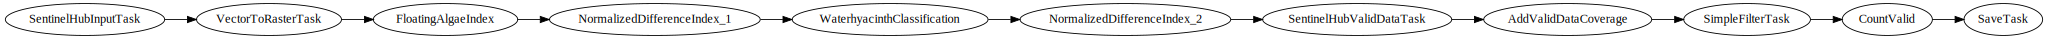

In [ ]:
#Specify nodes
node1 = EONode(add_data, name='SentinelHubInputTask')
node2 = EONode(add_nominal_water, inputs=[node1])
node3 = EONode(fai, inputs=[node2])
node4 = EONode(ndvi, inputs=[node3])
node5 = EONode(whc, inputs=[node4])
node6 = EONode(plastic, inputs=[node5])
node7 = EONode(add_sh_validmask, inputs=[node6])
node8 = EONode(add_coverage, inputs=[node7])
node9 = EONode(filter_task, inputs=[node8])
node10 = EONode(count_val_sh, inputs=[node9])
node11 = EONode(save, inputs=[node10])

workflow = EOWorkflow([node1, node2, node3, node4, node5, node6, node7, node8, node9, node10, node11])
workflow.dependency_graph('graph.png')

### 6.4 Execute the workflow for each patch

In [ ]:
%%time

# Execute the workflow
# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        node1:{'bbox': bbox, 'time_interval': time_interval},
        node11: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=3, multiprocess=True)

executor.make_report()

  0%|          | 0/9 [00:00<?, ?it/s]

/usr/lib/python3.11/multiprocessing/queues.py:122: EODeprecationWarning: "OVERWRITE_PATCH" permission is deprecated and will be removed in a future version
  return _ForkingPickler.loads(res)
DEBUG:eolearn.core.eoworkflow:Computing SentinelHubInputTask(*[], **{'bbox': BBox(((658364.0533980224, 1512357.8118474018), (661573.867571024, 1525854.3538712887)), crs=CRS('32647')), 'time_interval': ['2024-06-01', '2025-06-01']})
/usr/lib/python3.11/multiprocessing/queues.py:122: EODeprecationWarning: "OVERWRITE_PATCH" permission is deprecated and will be removed in a future version
  return _ForkingPickler.loads(res)
/usr/lib/python3.11/multiprocessing/queues.py:122: EODeprecationWarning: "OVERWRITE_PATCH" permission is deprecated and will be removed in a future version
  return _ForkingPickler.loads(res)
DEBUG:eolearn.core.eoworkflow:Computing SentinelHubInputTask(*[], **{'bbox': BBox(((661573.867571024, 1512357.8118474018), (664783.6817440256, 1525854.3538712887)), crs=CRS('32647')), 'time_in

CPU times: user 5.45 s, sys: 1.21 s, total: 6.66 s
Wall time: 10min 54s


### 6.5 Loop to create a list with dates in which each patch contains the same dates

In [ ]:
from eolearn.core import EOPatch
import numpy as np

# Define EOPatch paths for uppermost area
eop_locations = [
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatch_5',
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatch_8',
]

# Load EOPatches (not lazy)
eopatches = []
for loc in eop_locations:
    try:
        eop = EOPatch.load(loc, lazy_loading=False)
        eopatches.append(eop)
    except Exception as e:
        print(f"Could not load EOPatch at {loc}: {e}")

# Collect all unique timestamps (no filtering)
dt_list = set()
for eop in eopatches:
    dt_list.update(eop.timestamps)

dt_list = sorted(list(dt_list))
date_list_1 = [dt.strftime('%m/%d/%Y') for dt in dt_list]


# Output result
print("All unique timestamps across upper area patches:", date_list_1)




All unique timestamps across upper area patches: ['06/04/2024', '06/14/2024', '06/19/2024', '08/08/2024', '09/27/2024', '10/07/2024', '10/12/2024', '10/17/2024', '10/22/2024', '11/01/2024', '11/11/2024', '11/16/2024', '11/21/2024', '11/26/2024', '12/01/2024', '12/06/2024', '12/11/2024', '12/21/2024', '12/31/2024', '01/05/2025', '01/10/2025', '01/15/2025', '01/20/2025', '01/25/2025', '01/30/2025', '02/04/2025', '02/09/2025', '02/14/2025', '02/19/2025', '03/01/2025', '03/06/2025', '03/16/2025', '03/26/2025', '04/20/2025', '04/25/2025']


In [ ]:
from eolearn.core import EOPatch
import numpy as np

# Define EOPatch paths for middle-upper area
eop_locations = [
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatch_4',
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatch_7'
]

# Load EOPatches (not lazy)
eopatches = []
for loc in eop_locations:
    try:
        eop = EOPatch.load(loc, lazy_loading=False)
        eopatches.append(eop)
    except Exception as e:
        print(f"Could not load EOPatch at {loc}: {e}")

# Collect all unique timestamps (no filtering)
dt_list = set()
for eop in eopatches:
    dt_list.update(eop.timestamps)

dt_list = sorted(list(dt_list))
date_list_2 = [dt.strftime('%m/%d/%Y') for dt in dt_list]


# Output result
print("All unique timestamps across upper area patches:", date_list_2)


All unique timestamps across upper area patches: ['06/04/2024', '06/14/2024', '06/19/2024', '07/14/2024', '08/08/2024', '10/17/2024', '10/22/2024', '11/01/2024', '11/11/2024', '11/16/2024', '11/21/2024', '11/26/2024', '12/01/2024', '12/06/2024', '12/11/2024', '12/16/2024', '12/21/2024', '12/31/2024', '01/05/2025', '01/10/2025', '01/15/2025', '01/20/2025', '01/25/2025', '01/30/2025', '02/04/2025', '02/09/2025', '02/14/2025', '02/19/2025', '03/01/2025', '03/06/2025', '03/16/2025', '03/26/2025', '04/20/2025', '04/25/2025']


In [ ]:
from eolearn.core import EOPatch
import numpy as np

# Define paths for middle-lower area EOPatches
eop_locations = [
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatch_1',
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatch_3'
]

# Load EOPatches (not lazy!)
eopatches = []
for loc in eop_locations:
    try:
        eop = EOPatch.load(loc, lazy_loading=False)
        eopatches.append(eop)
    except Exception as e:
        print(f"Could not load EOPatch at {loc}: {e}")

# Collect all unique timestamps across patches
dt_list = set()
for eop in eopatches:
    dt_list.update(eop.timestamps)

dt_list = sorted(list(dt_list))
date_list_3 = [dt.strftime('%m/%d/%Y') for dt in dt_list]


# Output result
print("All unique timestamps across middle area patches:", date_list_3)


All unique timestamps across middle area patches: ['06/14/2024', '06/19/2024', '08/08/2024', '10/07/2024', '10/22/2024', '11/01/2024', '11/11/2024', '11/16/2024', '11/21/2024', '11/26/2024', '12/01/2024', '12/06/2024', '12/11/2024', '12/16/2024', '12/21/2024', '12/26/2024', '12/31/2024', '01/05/2025', '01/10/2025', '01/15/2025', '01/20/2025', '01/25/2025', '01/30/2025', '02/04/2025', '02/09/2025', '02/14/2025', '03/01/2025', '03/06/2025', '03/16/2025', '03/26/2025', '04/20/2025', '04/25/2025']


In [ ]:
from eolearn.core import EOPatch
import numpy as np
import os

# Define paths for lower area EOPatches
eop_locations = [
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatch_0',
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatch_2',
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatch_6'
]

# Fully load available EOPatches
eopatches = []
for loc in eop_locations:
    if os.path.exists(loc):
        try:
            eop = EOPatch.load(loc, lazy_loading=False)  # ✅ No lazy loading
            eopatches.append(eop)
        except Exception as e:
            print(f"Could not load EOPatch at {loc}: {e}")
    else:
        print(f"EOPatch directory does not exist: {loc}")

# Collect all unique timestamps from loaded patches
dt_list = set()
for eop in eopatches:
    dt_list.update(eop.timestamps)

dt_list = sorted(list(dt_list))
date_list_4 = [dt.strftime('%m/%d/%Y') for dt in dt_list]


# Print result
print("All unique timestamps across lower area patches:", date_list_4)


All unique timestamps across lower area patches: ['06/14/2024', '06/19/2024', '08/08/2024', '10/07/2024', '10/22/2024', '11/01/2024', '11/11/2024', '11/16/2024', '11/21/2024', '11/26/2024', '12/01/2024', '12/06/2024', '12/11/2024', '12/21/2024', '12/26/2024', '12/31/2024', '01/05/2025', '01/10/2025', '01/15/2025', '01/20/2025', '01/25/2025', '01/30/2025', '02/04/2025', '02/09/2025', '02/14/2025', '03/01/2025', '03/06/2025', '03/11/2025', '03/16/2025', '03/18/2025', '03/26/2025', '04/20/2025', '04/25/2025']


In [ ]:
print(date_list_1)
print(date_list_2)
print(date_list_3)
print(date_list_4)

['06/04/2024', '06/14/2024', '06/19/2024', '08/08/2024', '09/27/2024', '10/07/2024', '10/12/2024', '10/17/2024', '10/22/2024', '11/01/2024', '11/11/2024', '11/16/2024', '11/21/2024', '11/26/2024', '12/01/2024', '12/06/2024', '12/11/2024', '12/21/2024', '12/31/2024', '01/05/2025', '01/10/2025', '01/15/2025', '01/20/2025', '01/25/2025', '01/30/2025', '02/04/2025', '02/09/2025', '02/14/2025', '02/19/2025', '03/01/2025', '03/06/2025', '03/16/2025', '03/26/2025', '04/20/2025', '04/25/2025']
['06/04/2024', '06/14/2024', '06/19/2024', '07/14/2024', '08/08/2024', '10/17/2024', '10/22/2024', '11/01/2024', '11/11/2024', '11/16/2024', '11/21/2024', '11/26/2024', '12/01/2024', '12/06/2024', '12/11/2024', '12/16/2024', '12/21/2024', '12/31/2024', '01/05/2025', '01/10/2025', '01/15/2025', '01/20/2025', '01/25/2025', '01/30/2025', '02/04/2025', '02/09/2025', '02/14/2025', '02/19/2025', '03/01/2025', '03/06/2025', '03/16/2025', '03/26/2025', '04/20/2025', '04/25/2025']
['06/14/2024', '06/19/2024', '08

### 6.6 Cloud masking system to create masks based on 10m resolution

In [ ]:
from eolearn.core import EOTask, EOPatch, LoadTask, SaveTask, FeatureType, OverwritePermission
import numpy as np
import os
from skimage.transform import resize

# Set path to output folder and create load/save tasks
path_out = './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/'
path_out_sampled = './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled'

if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)

load = LoadTask(path_out, lazy_loading=True)
save = SaveTask(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# create a list of dates that can be used as filter to exclude images that do not overlap area of interest completely
def dt_list_filter(date, date_list, tolerance):
    return np.min(np.abs(date - np.array(date_list))) <= tolerance

# Cloud masking task
class cloud_mask(EOTask):
    def __init__(self, feature_name):
        self.feature_name = feature_name

    def execute(self, eopatch):
        clm = eopatch.mask["CLM"]
        scl = eopatch.mask["SCL"]

        valid_clm = clm == 1
        valid_scl = (scl == 4) | (scl == 5) | (scl == 6)

        valid_scl_resized = np.zeros_like(valid_clm, dtype=bool)
        for t in range(valid_clm.shape[0]):
            valid_scl_resized[t, ..., 0] = resize(
                valid_scl[t, ..., 0],
                (valid_clm.shape[1], valid_clm.shape[2]),
                order=0,
                preserve_range=True
            ).astype(bool)

        valid_mask = valid_clm | valid_scl_resized
        eopatch[FeatureType.MASK][self.feature_name] = valid_mask
        return eopatch

# Create instance of the mask task
cloud_mask2 = cloud_mask('VALID_MASK')

# # Loop over EOPatches manually
# for i in range(9):
#     patch_name = f'eopatch_{i}'
#     try:
#         # Load patch
#         eopatch = load.execute(eopatch_folder=patch_name)

#         # Apply cloud masking
#         eopatch = cloud_mask2.execute(eopatch)

#         # Save patch
#         save.execute(eopatch=eopatch, eopatch_folder=patch_name)

#         print(f"{patch_name} processed successfully.")
#     except Exception as e:
#         print(f"Failed to process {patch_name}: {e}")

# Assumes dt_list is already defined as a list of datetime objects
filter_task2 = SimpleFilterTask(
    feature='timestamps',
    filter_func=partial(dt_list_filter, date_list=dt_list, tolerance=timedelta(days=0))
)



/tmp/ipython-input-38-797341403.py:14: EODeprecationWarning: "OVERWRITE_PATCH" permission is deprecated and will be removed in a future version
  save = SaveTask(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)


### 6.7 Define the workflow #2

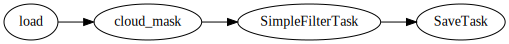

In [ ]:
# Define the workflow #2

newnode1 = EONode(load, name='load')
newnode2 = EONode(cloud_mask2, inputs=[newnode1])
newnode3 = EONode(filter_task2, inputs=[newnode2])
newnode4 = EONode(save, inputs=[newnode3])

workflow2 = EOWorkflow([newnode1, newnode2, newnode3, newnode4])
workflow2.dependency_graph('graph.png')

### 6.8 Execute the workflow for each patch #2
In this workflow we are filtering the images in order to exclude cloudy pixels and images that do not completely cover the area of interest

In [ ]:
%%time

execution_args = []
for idx in range(9):
    execution_args.append({
        newnode1: {'eopatch_folder': f'eopatch_{idx}'},
        newnode4: {'eopatch_folder': f'eopatch_{idx}'}
    })

executor = EOExecutor(workflow2, execution_args, save_logs=True)
executor.run(workers=1, multiprocess=False)

executor.make_report()

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:eolearn.core.eoworkflow:Computing LoadTask(*[], **{'eopatch_folder': 'eopatch_0'})
DEBUG:eolearn.core.eoworkflow:Computing cloud_mask(*[EOPatch(
  bbox=BBox(((658364.0533980224, 1512357.8118474018), (661573.867571024, 1525854.3538712887)), crs=CRS('32647'))
  timestamps=[2024-06-14 03:54:28, ...]<length=31>
  data={
    BANDS: FeatureIONumpy(/eopatch_0/data/BANDS.npy.gz)
    CLP: FeatureIONumpy(/eopatch_0/data/CLP.npy.gz)
    FAI: FeatureIONumpy(/eopatch_0/data/FAI.npy.gz)
    NDVI: FeatureIONumpy(/eopatch_0/data/NDVI.npy.gz)
    PLASTIC: FeatureIONumpy(/eopatch_0/data/PLASTIC.npy.gz)
    WHC: FeatureIONumpy(/eopatch_0/data/WHC.npy.gz)
  }
  mask={
    CLM: FeatureIONumpy(/eopatch_0/mask/CLM.npy.gz)
    IS_DATA: FeatureIONumpy(/eopatch_0/mask/IS_DATA.npy.gz)
    IS_VALID: FeatureIONumpy(/eopatch_0/mask/IS_VALID.npy.gz)
    SCL: FeatureIONumpy(/eopatch_0/mask/SCL.npy.gz)
  }
  scalar={
    COVERAGE: FeatureIONumpy(/eopatch_0/scalar/COVERAGE.npy.gz)
  }
  mask_timeless={
    NOMINA

KeyboardInterrupt: 

In [ ]:
# from eolearn.core import EOPatch, EOTask, LoadTask, SaveTask, FeatureType, OverwritePermission
# import os
# import numpy as np
# from skimage.transform import resize

# # === Set your paths ===
# path_in = './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/'  # original full patches
# path_out = './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled/'  # where new patches will go

# # Ensure output directory exists
# os.makedirs(path_out, exist_ok=True)

# # === Load & Save tasks ===
# load = LoadTask(path_in, lazy_loading=True)
# save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# # === Optional cloud mask task ===
# class CloudMask(EOTask):
#     def __init__(self, feature_name):
#         self.feature_name = feature_name

#     def execute(self, eopatch):
#         clm = eopatch.mask['CLM']
#         scl = eopatch.mask['SCL']
#         valid_clm = clm == 1
#         valid_scl = (scl == 4) | (scl == 5) | (scl == 6)

#         valid_scl_resized = np.zeros_like(valid_clm, dtype=bool)
#         for t in range(valid_clm.shape[0]):
#             valid_scl_resized[t, ..., 0] = resize(
#                 valid_scl[t, ..., 0],
#                 (valid_clm.shape[1], valid_clm.shape[2]),
#                 order=0,
#                 preserve_range=True
#             ).astype(bool)

#         valid_mask = valid_clm | valid_scl_resized
#         eopatch[FeatureType.MASK][self.feature_name] = valid_mask
#         return eopatch

# cloud_mask_task = CloudMask('VALID_MASK')

# # === Rebuild all 9 patches ===
# for i in range(9):
#     patch_name = f'eopatch_{i}'
#     try:
#         print(f"Processing {patch_name}...")
#         eop = load.execute(eopatch_folder=patch_name)
#         eop = cloud_mask_task.execute(eop)  # optional step
#         save.execute(eopatch=eop, eopatch_folder=patch_name)
#         print(f"{patch_name} saved ✅")
#     except Exception as e:
#         print(f"❌ Failed to process {patch_name}: {e}")


/tmp/ipython-input-41-3824754304.py:15: EODeprecationWarning: "OVERWRITE_PATCH" permission is deprecated and will be removed in a future version
  save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)


Processing eopatch_0...


KeyboardInterrupt: 

### 6.9 Lazy load eopatches, extract values and insert them into a list

In [ ]:
from eolearn.core import EOPatch
import os
import numpy as np

# Define base path
base_path = './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled/'
eop_locations = [os.path.join(base_path, f"eopatch_{i}") for i in range(9)]

# Load all valid EOPatches fully
eopatches = []
for loc in eop_locations:
    if os.path.exists(loc):
        try:
            eop = EOPatch.load(loc, lazy_loading=False)  # ✅ FULL load
            eopatches.append(eop)
        except Exception as e:
            print(f"Failed to load {loc}: {e}")
    else:
        print(f"Missing: {loc}")

# Collect and format all unique timestamps
all_dates = set()
for eop in eopatches:
    all_dates.update(eop.timestamps)

# Sort and format
all_dates = sorted(all_dates)
date_list_sampled = [d.strftime('%m/%d/%Y') for d in all_dates]

# Output result
print("All unique timestamps across available EOPatches:")
print(date_list_sampled)


All unique timestamps across available EOPatches:
['06/04/2024', '06/14/2024', '06/19/2024', '07/14/2024', '08/08/2024', '09/27/2024', '10/07/2024', '10/12/2024', '10/17/2024', '10/22/2024', '11/01/2024', '11/11/2024', '11/16/2024', '11/21/2024', '11/26/2024', '12/01/2024', '12/06/2024', '12/11/2024', '12/16/2024', '12/21/2024', '12/26/2024', '12/31/2024', '01/05/2025', '01/10/2025', '01/15/2025', '01/20/2025', '01/25/2025', '01/30/2025', '02/04/2025', '02/09/2025', '02/14/2025', '02/19/2025', '03/01/2025', '03/06/2025', '03/11/2025', '03/16/2025', '03/18/2025', '03/26/2025', '04/20/2025', '04/25/2025']


In [ ]:
from eolearn.core import EOPatch
import numpy as np

# Lazy load upstream area (patches 5, 8, 4, 7)
eop_locations_upstream = [
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled/eopatch_5',
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled/eopatch_8',
]

eopatches_upstream = []
for loc in eop_locations_upstream:
    try:
        eop = EOPatch.load(loc, lazy_loading=False)
        eopatches_upstream.append(eop)
    except Exception as e:
        print(f"Failed to load {loc}: {e}")

# Print timestamps per patch
for i, eop in enumerate(eopatches_upstream):
    print(f"EOPatch {i} timestamps: {[ts.strftime('%Y-%m-%d') for ts in eop.timestamps]}")

# Collect all unique timestamps across upstream patches
all_dates_upstream = set()
for eop in eopatches_upstream:
    all_dates_upstream.update(eop.timestamps)

# Sort and format
all_dates_upstream = sorted(list(all_dates_upstream))
date_list_sampled_upstream = [d.strftime('%m/%d/%Y') for d in all_dates_upstream]

# Print final date list
print(f"\nAll unique timestamps in upstream patches: {date_list_sampled_upstream}")


EOPatch 0 timestamps: ['2024-06-04', '2024-06-14', '2024-06-19', '2024-08-08', '2024-09-27', '2024-10-07', '2024-10-12', '2024-10-17', '2024-10-22', '2024-11-01', '2024-11-11', '2024-11-16', '2024-11-21', '2024-11-26', '2024-12-01', '2024-12-06', '2024-12-11', '2024-12-21', '2024-12-31', '2025-01-05', '2025-01-10', '2025-01-15', '2025-01-20', '2025-01-25', '2025-01-30', '2025-02-04', '2025-02-09', '2025-02-14', '2025-03-01', '2025-03-06', '2025-03-16', '2025-03-26', '2025-04-20', '2025-04-25']
EOPatch 1 timestamps: ['2024-06-04', '2024-06-14', '2024-06-19', '2024-08-08', '2024-09-27', '2024-10-07', '2024-10-12', '2024-10-17', '2024-10-22', '2024-11-01', '2024-11-11', '2024-11-16', '2024-11-21', '2024-11-26', '2024-12-01', '2024-12-06', '2024-12-11', '2024-12-21', '2024-12-31', '2025-01-05', '2025-01-10', '2025-01-15', '2025-01-20', '2025-01-25', '2025-01-30', '2025-02-04', '2025-02-09', '2025-02-14', '2025-02-19', '2025-03-01', '2025-03-06', '2025-03-16', '2025-04-20', '2025-04-25']

A

In [ ]:
from eolearn.core import EOPatch
import numpy as np

# Lazy load upstream area (patches 5, 8, 4, 7)
eop_locations_mid_upstream = [
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled/eopatch_4',
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled/eopatch_7'
]

eopatches_mid_upstream = []
for loc in eop_locations_mid_upstream:
    try:
        eop = EOPatch.load(loc, lazy_loading=False)
        eopatches_mid_upstream.append(eop)
    except Exception as e:
        print(f"Failed to load {loc}: {e}")

# Print timestamps per patch
for i, eop in enumerate(eopatches_mid_upstream):
    print(f"EOPatch {i} timestamps: {[ts.strftime('%Y-%m-%d') for ts in eop.timestamps]}")

# Collect all unique timestamps across upstream patches
all_dates_mid_upstream = set()
for eop in eopatches_mid_upstream:
    all_dates_mid_upstream.update(eop.timestamps)

# Sort and format
all_dates_mid_upstream = sorted(list(all_dates_mid_upstream))
date_list_sampled_mid_upstream = [d.strftime('%m/%d/%Y') for d in all_dates_mid_upstream]

# Print final date list
print(f"\nAll unique timestamps in upstream patches: {date_list_sampled_mid_upstream}")


EOPatch 0 timestamps: ['2024-06-04', '2024-06-14', '2024-06-19', '2024-08-08', '2024-10-22', '2024-11-01', '2024-11-11', '2024-11-16', '2024-11-21', '2024-11-26', '2024-12-01', '2024-12-06', '2024-12-11', '2024-12-16', '2024-12-21', '2024-12-31', '2025-01-05', '2025-01-10', '2025-01-15', '2025-01-20', '2025-01-25', '2025-01-30', '2025-02-04', '2025-02-09', '2025-02-14', '2025-02-19', '2025-03-01', '2025-03-06', '2025-03-16', '2025-04-20', '2025-04-25']
EOPatch 1 timestamps: ['2024-06-04', '2024-06-14', '2024-06-19', '2024-07-14', '2024-08-08', '2024-10-17', '2024-10-22', '2024-11-01', '2024-11-11', '2024-11-16', '2024-11-21', '2024-11-26', '2024-12-01', '2024-12-06', '2024-12-11', '2024-12-16', '2024-12-21', '2024-12-31', '2025-01-05', '2025-01-10', '2025-01-15', '2025-01-20', '2025-01-25', '2025-01-30', '2025-02-04', '2025-02-09', '2025-02-14', '2025-02-19', '2025-03-01', '2025-03-06', '2025-03-16', '2025-03-26', '2025-04-20', '2025-04-25']

All unique timestamps in upstream patches: 

In [ ]:
from eolearn.core import EOPatch
import numpy as np

# Lazy load midstream area (patches 1, 3)
eop_locations_midstream = [
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled/eopatch_1',
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled/eopatch_3',
]

# Load patches
eopatches_midstream = []
for loc in eop_locations_midstream:
    try:
        eop = EOPatch.load(loc, lazy_loading=False)
        eopatches_midstream.append(eop)
    except Exception as e:
        print(f"Failed to load {loc}: {e}")

# Print timestamps per patch
for i, eop in enumerate(eopatches_midstream):
    print(f"EOPatch {i} timestamps: {[ts.strftime('%Y-%m-%d') for ts in eop.timestamps]}")

# Collect all unique timestamps from midstream patches
all_dates_midstream = set()
for eop in eopatches_midstream:
    all_dates_midstream.update(eop.timestamps)

# Sort and format
all_dates_midstream = sorted(all_dates_midstream)
date_list_sampled_2 = [d.strftime('%m/%d/%Y') for d in all_dates_midstream]

# Print final date list
print(f"\nAll unique timestamps in midstream patches: {date_list_sampled_2}")


EOPatch 0 timestamps: ['2024-06-14', '2024-06-19', '2024-08-08', '2024-10-22', '2024-11-01', '2024-11-11', '2024-11-16', '2024-11-21', '2024-11-26', '2024-12-01', '2024-12-06', '2024-12-11', '2024-12-16', '2024-12-21', '2024-12-26', '2024-12-31', '2025-01-05', '2025-01-10', '2025-01-15', '2025-01-20', '2025-01-25', '2025-01-30', '2025-02-04', '2025-02-09', '2025-02-14', '2025-03-01', '2025-03-06', '2025-03-16', '2025-04-20', '2025-04-25']
EOPatch 1 timestamps: ['2024-06-14', '2024-06-19', '2024-08-08', '2024-10-07', '2024-10-22', '2024-11-01', '2024-11-11', '2024-11-16', '2024-11-21', '2024-11-26', '2024-12-01', '2024-12-06', '2024-12-11', '2024-12-16', '2024-12-21', '2024-12-26', '2024-12-31', '2025-01-05', '2025-01-10', '2025-01-15', '2025-01-20', '2025-01-25', '2025-01-30', '2025-02-04', '2025-02-09', '2025-02-14', '2025-03-01', '2025-03-06', '2025-03-16', '2025-03-26', '2025-04-20', '2025-04-25']

All unique timestamps in midstream patches: ['06/14/2024', '06/19/2024', '08/08/2024'

In [ ]:
from eolearn.core import EOPatch
import numpy as np

# Lazy load downstream area (patches 0, 2, 6)
eop_locations_downstream = [
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled/eopatch_0',
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled/eopatch_2',
    './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled/eopatch_6',
]

# Load EOPatches
eopatches_downstream = []
for loc in eop_locations_downstream:
    try:
        eop = EOPatch.load(loc, lazy_loading=True)
        eopatches_downstream.append(eop)
    except Exception as e:
        print(f"Failed to load {loc}: {e}")

# Print timestamps per patch
for i, eop in enumerate(eopatches_downstream):
    print(f"EOPatch {i} timestamps: {[ts.strftime('%Y-%m-%d') for ts in eop.timestamps]}")

# Collect all unique timestamps from downstream patches
all_dates_downstream = set()
for eop in eopatches_downstream:
    all_dates_downstream.update(eop.timestamps)

# Sort and format
all_dates_downstream = sorted(all_dates_downstream)
date_list_sampled_3 = [d.strftime('%m/%d/%Y') for d in all_dates_downstream]

# Print final date list
print(f"\nAll unique timestamps in downstream patches: {date_list_sampled_3}")


EOPatch 0 timestamps: ['2024-06-14', '2024-06-19', '2024-08-08', '2024-10-07', '2024-10-22', '2024-11-01', '2024-11-11', '2024-11-16', '2024-11-21', '2024-11-26', '2024-12-01', '2024-12-06', '2024-12-11', '2024-12-21', '2024-12-26', '2024-12-31', '2025-01-05', '2025-01-10', '2025-01-15', '2025-01-20', '2025-01-25', '2025-01-30', '2025-02-04', '2025-02-09', '2025-02-14', '2025-03-01', '2025-03-06', '2025-03-11', '2025-03-16', '2025-04-20', '2025-04-25']
EOPatch 1 timestamps: ['2024-06-14', '2024-06-19', '2024-08-08', '2024-10-07', '2024-10-22', '2024-11-01', '2024-11-11', '2024-11-16', '2024-11-26', '2024-12-01', '2024-12-06', '2024-12-11', '2024-12-21', '2024-12-26', '2024-12-31', '2025-01-05', '2025-01-10', '2025-01-15', '2025-01-20', '2025-01-25', '2025-01-30', '2025-02-04', '2025-02-09', '2025-02-14', '2025-03-01', '2025-03-06', '2025-03-11', '2025-03-16', '2025-03-18', '2025-03-26', '2025-04-20', '2025-04-25']
EOPatch 2 timestamps: ['2024-06-14', '2024-06-19', '2024-08-08', '2024-1

## 7. Visualise the processed imagery

### 7.1 correcting the location of patches


In [ ]:
# for correct location of patches within visusalization below we need to index them, this is done below.
#for full extent
# indexes = [[ 3,   7,  9],
#            [ 2,   6,   ],
#            [ 1,   5,   ],
#            [ 0,   4,  6]]

# places =  [[ 1,   2,  3],
#            [ 4,   5,  6],
#            [ 7,   8,  9],
#            [ 10,  11, 12]]

#for lower area
indexes = [[None, 5,  8],
           [None, 4,  7],
           [ 1,   3,   ],
           [ 0,   2,  6]]

places =  [[ 1,   2,  3],
           [ 4,   5,  6],
           [ 7,   8,  9],
           [ 10,  11, 12]]


### 7.2 Plot visible spectrum at a particular date

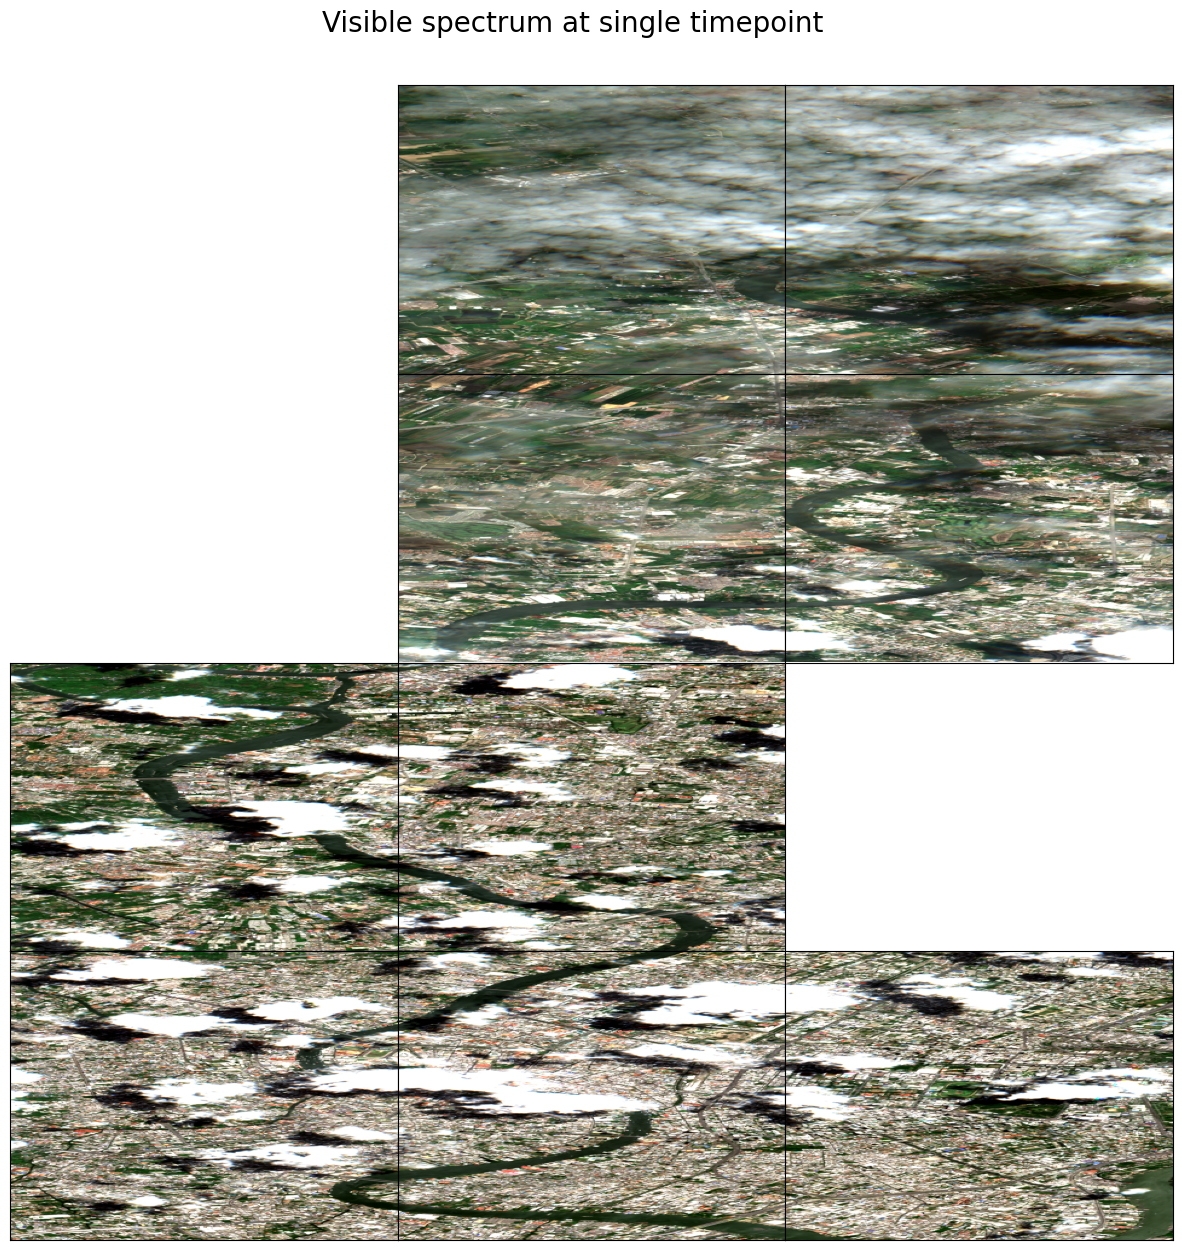

In [ ]:
from eolearn.core import EOPatch
import matplotlib.pyplot as plt
import numpy as np

path_out = './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled'
fig = plt.figure(figsize=(15, 15))
k = 0
date_idx = 0

for i, (idxs, plc) in enumerate(zip(indexes, places)):
    for j, (idx, p) in enumerate(zip(idxs, plc)):
        if idx is None:
            continue  # skip missing patches

        k = k + 1
        eopatch = EOPatch.load(f'{path_out}/eopatch_{idx}', lazy_loading=False)

        ax = plt.subplot(4, 3, p)
        plt.imshow(np.clip(eopatch.data['BANDS'][date_idx][..., [2, 1, 0]] * 3.5, 0, 1))
        plt.xticks([])
        plt.yticks([])
        ax.set_aspect("auto")
        del eopatch

fig.suptitle('Visible spectrum at single timepoint', y=0.93, size=20)
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig('Visible spectrum at single timepoint.jpg')


### 7.3 Take a closer look at a patch (classified Water Hyacinth)

/tmp/ipython-input-12-2082404922.py:28: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  date = eopatch.timestamp[date_idx]
/tmp/ipython-input-12-2082404922.py:33: EODeprecationWarning: The parameter `folder` has been renamed to `path`.
  EoPatch_0 = ExportToTiffTask(feature=(FeatureType.DATA, 'WHC'),
/tmp/ipython-input-12-2082404922.py:28: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  date = eopatch.timestamp[date_idx]
/tmp/ipython-input-12-2082404922.py:33: EODeprecationWarning: The parameter `folder` has been renamed to `path`.
  EoPatch_0 = ExportToTiffTask(feature=(FeatureType.DATA, 'WHC'),
/tmp/ipython-input-12-2082404922.py:28: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  date = eopatch.timestamp[date_idx]
/tmp/ipython-input-12-2082404922.py:33: EODeprecationWarning: The parameter `folder` has been renamed to `path`.
  EoPatch_0 = ExportToTiffTask(

date of imagery:  2025-04-25 03:54:47


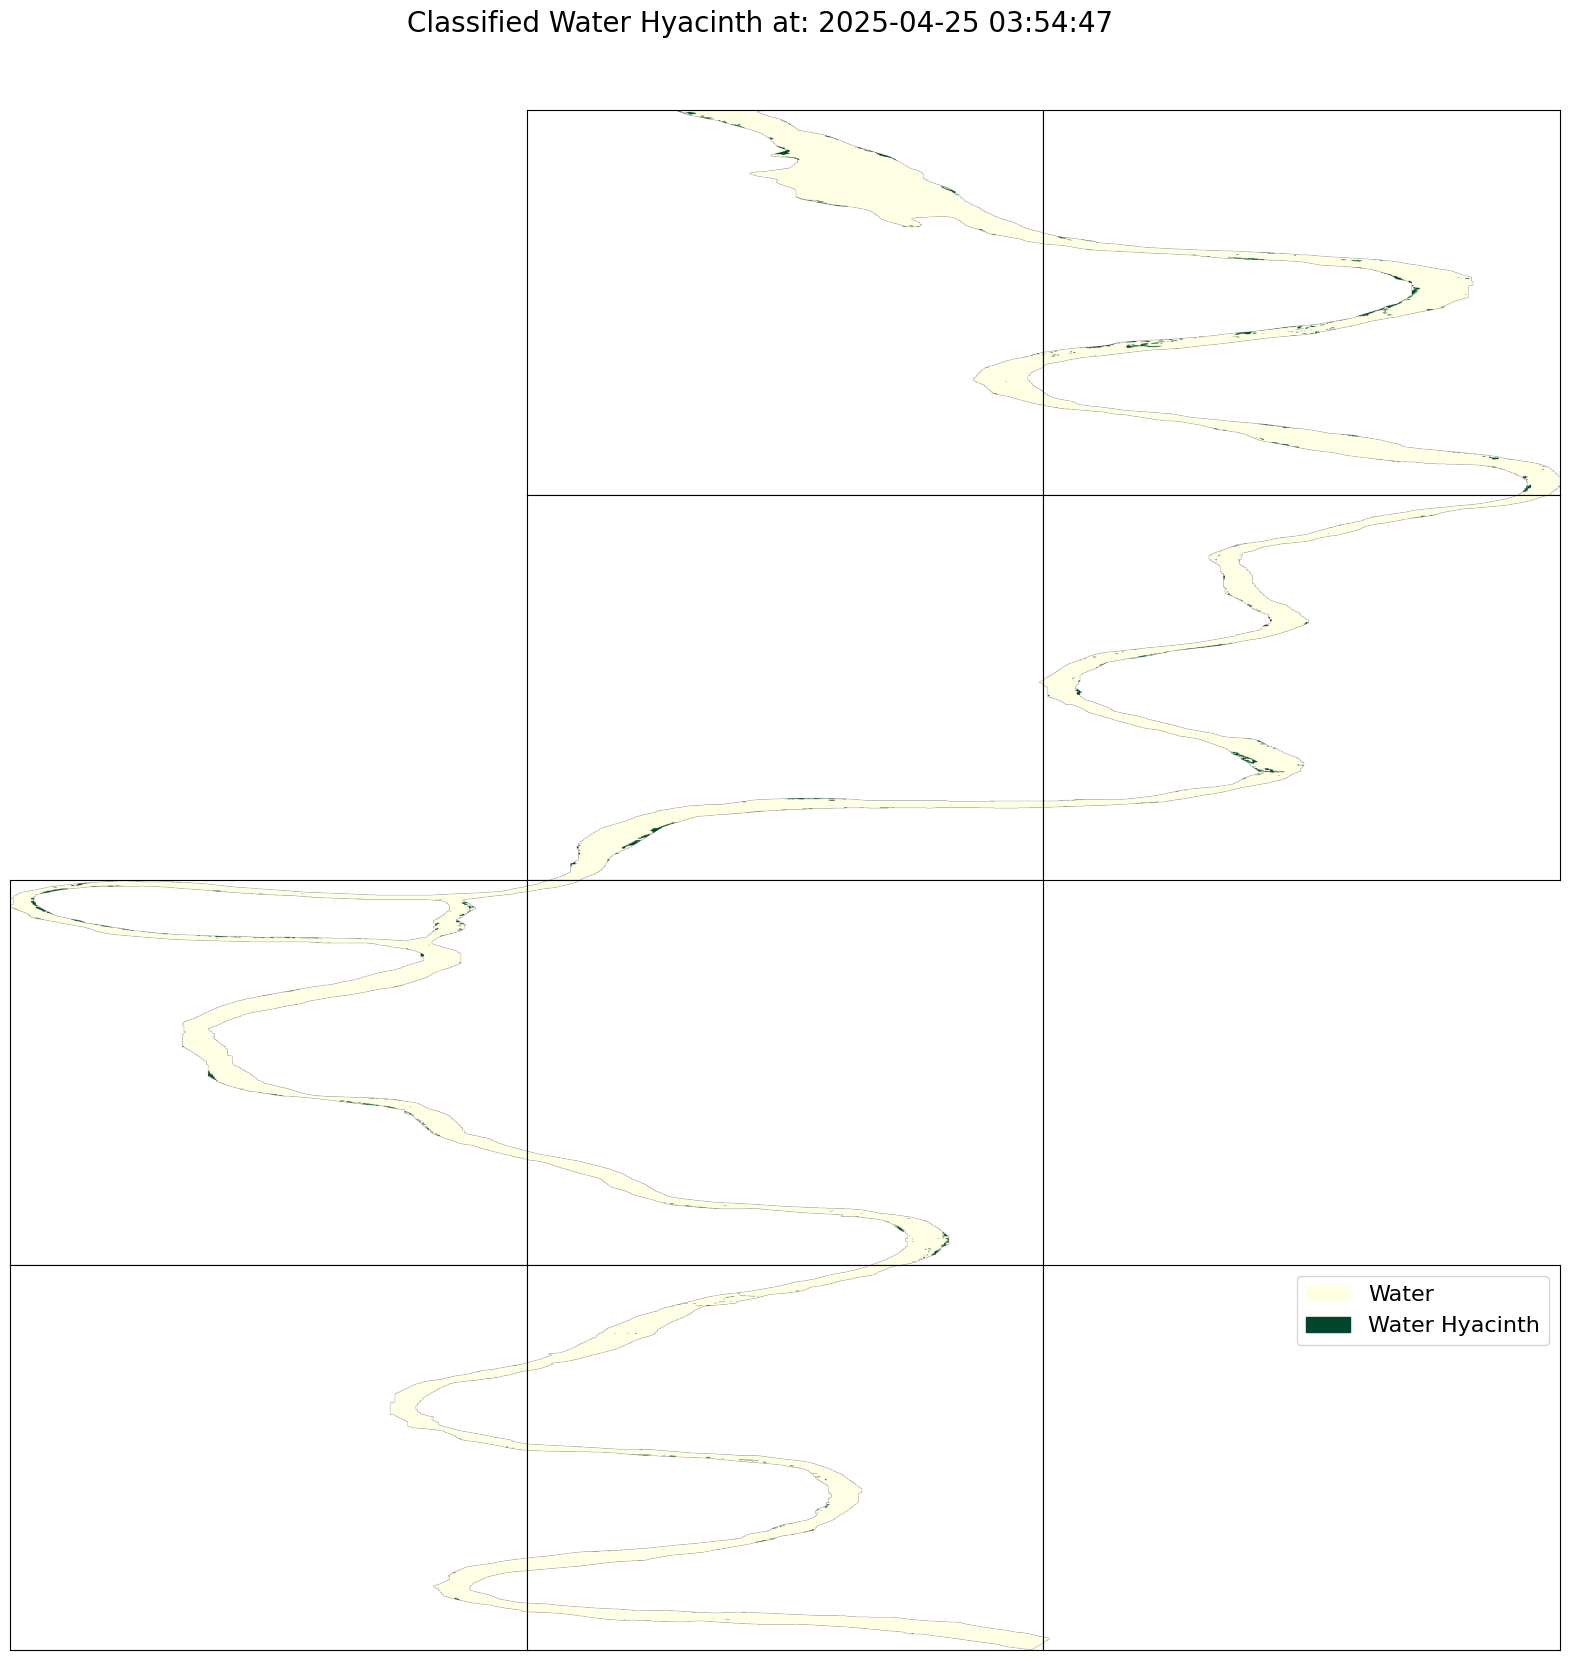

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from eolearn.core import EOPatch, FeatureType
from eolearn.io import ExportToTiffTask
from sentinelhub import CRS

path_out = './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled'

fig = plt.figure(figsize=(20, 20))
date_idx= -1
area = []

for i,  (idxs, plc) in enumerate(zip(indexes, places)):
    for j, (idx, p) in enumerate(zip(idxs, plc)):
        if idx is None:
            continue  # skip missing patches

        k=k+1
        eopatch = EOPatch.load(f'{path_out}/eopatch_{idx}', lazy_loading=True)
        ax = plt.subplot(4, 3, p)
        #mask = eopatch.mask['IS_VALID'][date_idx].astype(bool)
        mask1 = eopatch.mask_timeless['NOMINAL_WATER'].astype(bool) # mask of valid pixels
        cmi = eopatch.data['WHC'][date_idx]
        #cmi[~mask] = np.nan
        cmi[~mask1] = np.nan
        area = (np.count_nonzero(cmi == 1)) / 100
        date = eopatch.timestamp[date_idx]
        im = plt.imshow(cmi.squeeze(), cmap=plt.get_cmap('YlGn'))
        plt.xticks([])
        plt.yticks([])
        ax.set_aspect("auto")
        EoPatch_0 = ExportToTiffTask(feature=(FeatureType.DATA, 'WHC'),
                         folder="./drive/My Drive/SentinelModel/output_folder",
                         crs=CRS.UTM_47N)
        EoPatch_0.execute(eopatch, filename="s2_" + str(idx) + "}.tif")
        del eopatch


fig.subplots_adjust(wspace=0, hspace=0)
fig.suptitle('Classified Water Hyacinth at: ' + str(date), y=0.93, size=20)
print('date of imagery: ', date)
cmap=plt.get_cmap('YlGn')
my_colors = {
    'Water' : 1,
    'Water Hyacinth' : 2.0,
    }

patches = [mpatches.Patch(color=cmap(v), label=k) for k,v in my_colors.items()]

plt.legend(handles=patches, prop={'size': 16})
plt.savefig('./drive/My Drive/SentinelModel/figures/waterhyacinthcoverage.png', bbox_inches = "tight")
plt.show()
# plot and save figure


/tmp/ipython-input-13-2917085146.py:24: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  timestamps = [ts.date() for ts in eopatch.timestamp]
/tmp/ipython-input-13-2917085146.py:35: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  date = eopatch.timestamp[date_idx]
/tmp/ipython-input-13-2917085146.py:42: EODeprecationWarning: The parameter `folder` has been renamed to `path`.
  EoPatch_0 = ExportToTiffTask(
/tmp/ipython-input-13-2917085146.py:24: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  timestamps = [ts.date() for ts in eopatch.timestamp]
/tmp/ipython-input-13-2917085146.py:35: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  date = eopatch.timestamp[date_idx]
/tmp/ipython-input-13-2917085146.py:42: EODeprecationWarning: The parameter `folder` has been renamed to `path`.
  EoPatch_0 = ExportToTiffTask(
/tmp/ipyth

date of imagery:  2025-03-16 03:54:49


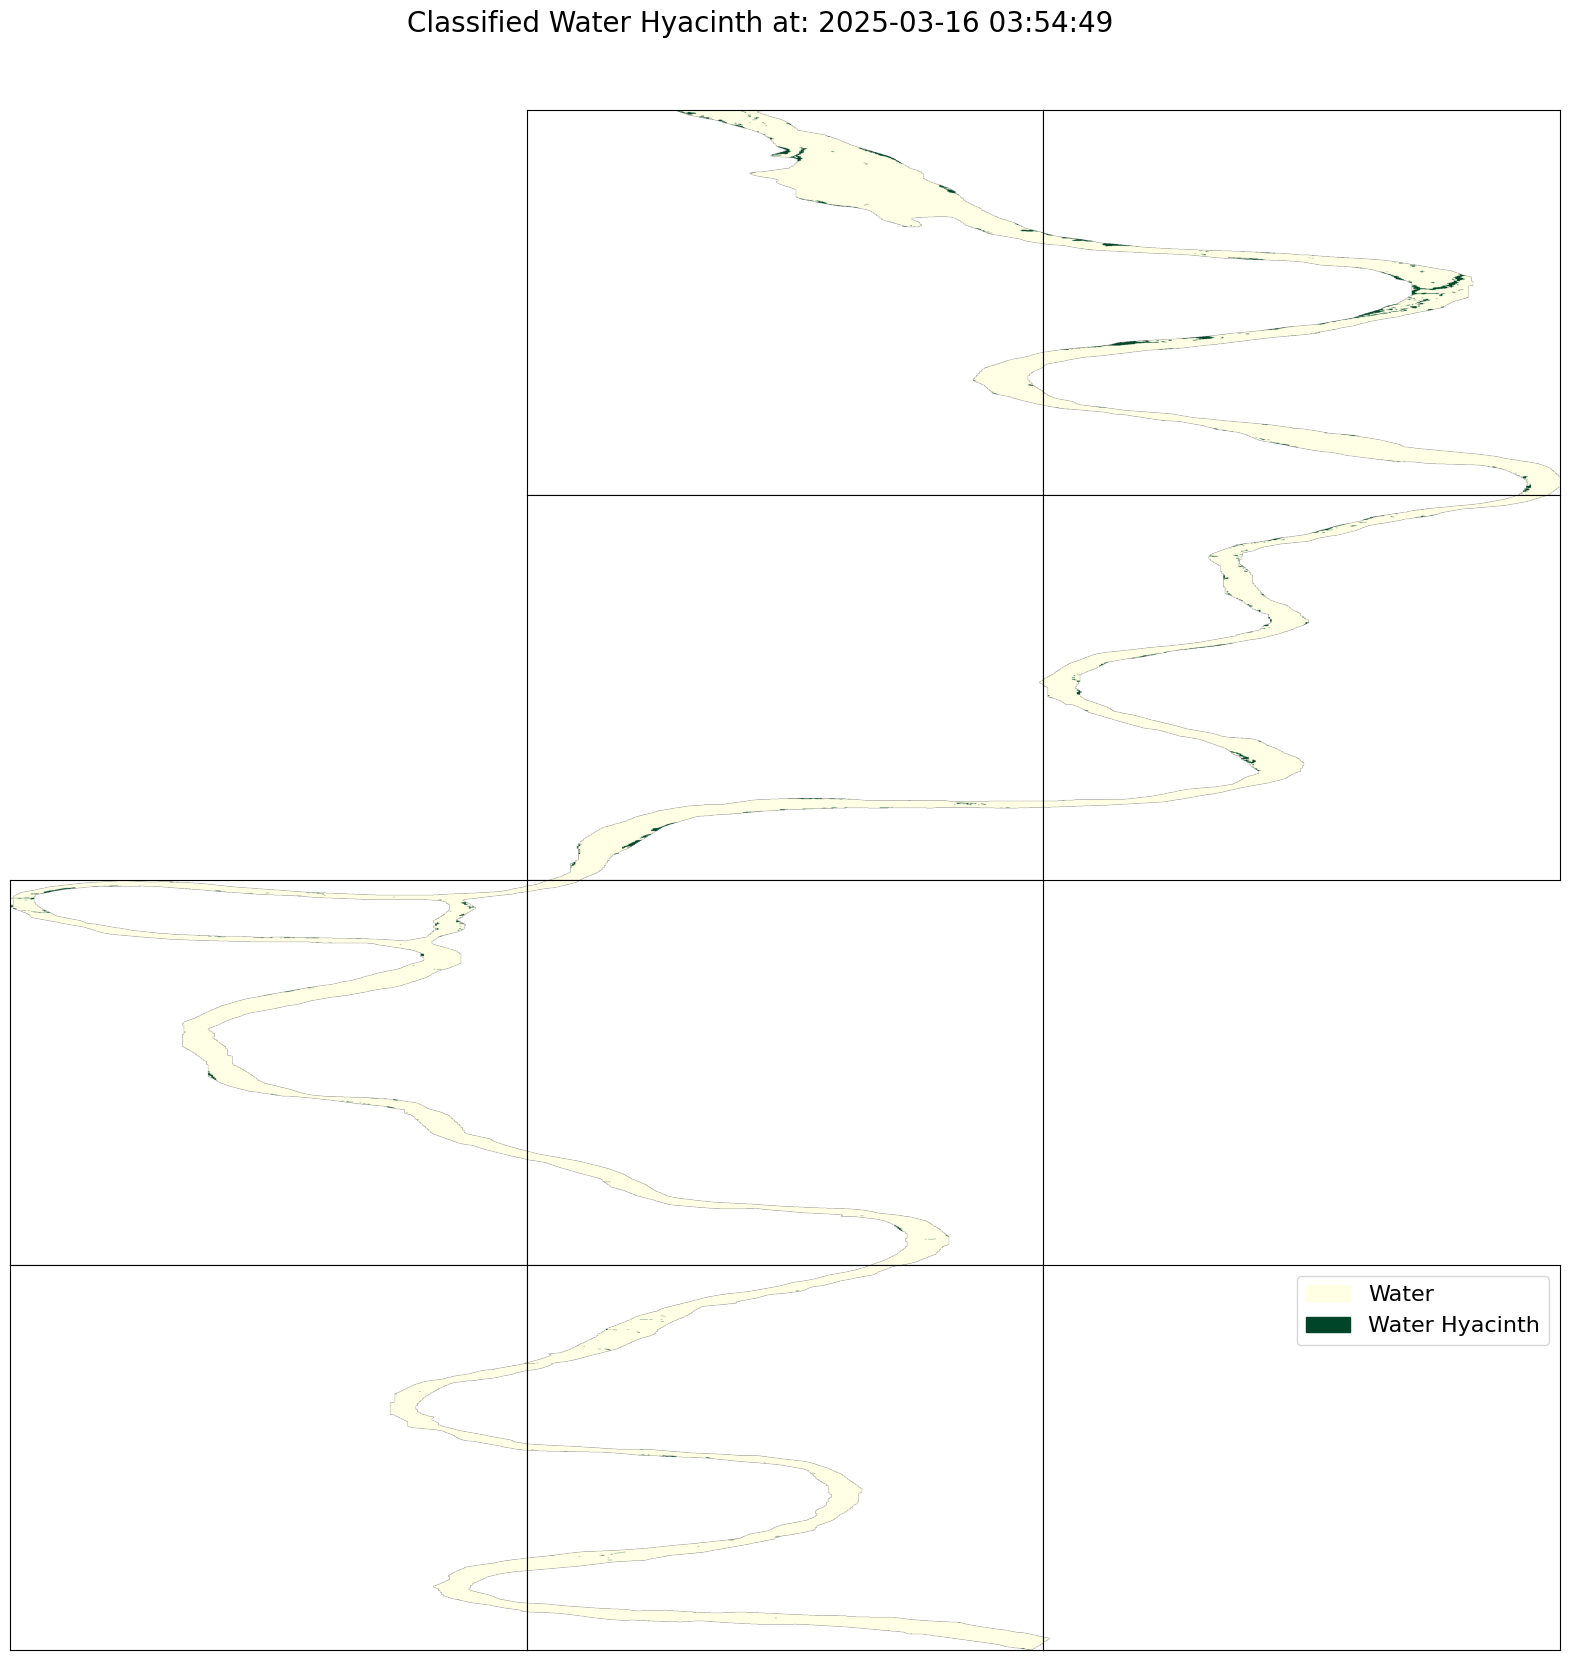

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from eolearn.core import EOPatch, FeatureType
from eolearn.io import ExportToTiffTask
from sentinelhub import CRS

path_out = './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled'

fig = plt.figure(figsize=(20, 20))
desired_date = datetime(2025, 3, 16).date()
area = []
k = 0  # Initialize counter

for i, (idxs, plc) in enumerate(zip(indexes, places)):
    for j, (idx, p) in enumerate(zip(idxs, plc)):
        if idx is None:
            continue  # skip missing patches

        k = k + 1
        eopatch = EOPatch.load(f'{path_out}/eopatch_{idx}', lazy_loading=True)

        # Find correct date index
        timestamps = [ts.date() for ts in eopatch.timestamp]
        if desired_date not in timestamps:
            print(f"Date {desired_date} not found in patch {idx}, skipping...")
            continue
        date_idx = timestamps.index(desired_date)

        ax = plt.subplot(4, 3, p)
        mask1 = eopatch.mask_timeless['NOMINAL_WATER'].astype(bool)  # mask of valid pixels
        cmi = eopatch.data['WHC'][date_idx]
        cmi[~mask1] = np.nan
        area = (np.count_nonzero(cmi == 1)) / 100
        date = eopatch.timestamp[date_idx]

        im = plt.imshow(cmi.squeeze(), cmap=plt.get_cmap('YlGn'))
        plt.xticks([])
        plt.yticks([])
        ax.set_aspect("auto")

        EoPatch_0 = ExportToTiffTask(
            feature=(FeatureType.DATA, 'WHC'),
            folder="./drive/My Drive/SentinelModel/output_folder",
            crs=CRS.UTM_47N
        )
        EoPatch_0.execute(eopatch, filename=f"s2_{idx}.tif")
        del eopatch

fig.subplots_adjust(wspace=0, hspace=0)
fig.suptitle('Classified Water Hyacinth at: ' + str(date), y=0.93, size=20)
print('date of imagery: ', date)

cmap = plt.get_cmap('YlGn')
my_colors = {
    'Water': 1,
    'Water Hyacinth': 2.0,
}
patches = [mpatches.Patch(color=cmap(v), label=k) for k, v in my_colors.items()]

plt.legend(handles=patches, prop={'size': 16})
plt.savefig('./drive/My Drive/SentinelModel/figures/waterhyacinthcoverage.png', bbox_inches="tight")
plt.show()


## 8 Plot results Water Hyacinth classification in hectares


### 8.1 Calculate the area (ha) covered for rivertotal, and river section per date


In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from eolearn.core import EOPatch

# --- SETTINGS ---

# Folder where your eopatches are stored
path_out = './drive/My Drive/SentinelModel/output_folder/eopatches_aoi/eopatches_aoi_sampled'

# Patch indices for the total set and for each area:
patch_indices_total     = list(range(9))  # example: patches 0 to 9
patch_indices_downstream = [0, 2, 6]
patch_indices_mid_upstream = [4, 7]
patch_indices_upstream   = [5, 8]
patch_indices_midstream  = [1,3]

# Parameters for processing
whc_class_value = 2   # the value in WHC that indicates water hyacinth
divisor = 100         # to convert pixel count into area units

# --- STEP 1: Determine Common Dates Automatically ---

def extract_dates_from_patch(patch_path):
    """Load an EOPatch and return a set of dates (as date objects) from its timestamps."""
    eopatch = EOPatch.load(patch_path, lazy_loading=False)
    # Extract dates assuming each timestamp is a datetime object
    dates = set(ts.date() for ts in eopatch.timestamps)
    return dates

# Use the total set of patches (or a representative subset) to compute the intersection of dates.
common_dates = None
for idx in patch_indices_total:
    patch_path = os.path.join(path_out, f"eopatch_{idx}")
    patch_dates = extract_dates_from_patch(patch_path)
    if common_dates is None:
        common_dates = patch_dates
    else:
        common_dates = common_dates.intersection(patch_dates)

# Convert the common dates set to a sorted list
date_list_sampled = sorted(common_dates)
print("Common dates across patches:", date_list_sampled)

# --- STEP 2: Define Helper Functions for Processing and Aggregation ---

def process_patch(patch_index, date_list, whc_class=2, divisor=100):
    """
    Load a patch, apply masks, filter the timestamps by the given date list, and compute
    per-date area (i.e. count of pixels with value==whc_class divided by divisor).

    Returns:
      filtered_times: numpy array of datetime objects (only for dates in date_list)
      areas: numpy array of computed area values for each date
    """
    patch_path = os.path.join(path_out, f"eopatch_{patch_index}")
    eopatch = EOPatch.load(patch_path, lazy_loading=True)

    # Apply the masks to the WHC data
    mask_valid = eopatch.mask['IS_VALID'].astype(bool)
    mask_water = eopatch.mask_timeless['NOMINAL_WATER'].astype(bool)
    whc = eopatch.data['WHC'].copy()  # shape: (time, w, h, channels)

    # Ensure mask_water has the same shape as whc
    mask_water = np.broadcast_to(mask_water, whc.shape)

    # Set invalid or non-water pixels to NaN
    whc[~mask_valid] = np.nan
    whc[~mask_water] = np.nan

    # Get timestamps from the patch
    times = np.array(eopatch.timestamps)

    # Filter indices by checking if the date of each timestamp is in date_list
    indices = [i for i, t in enumerate(times) if t.date() in date_list]

    if not indices:
        # If no timestamps match, return None values
        return None, None

    filtered_times = times[indices]

    # Reshape WHC data: assume shape is (t, w, h, channels)
    t_total, w, h, _ = whc.shape
    whc_reshaped = whc.reshape(t_total, w * h)

    # Only keep the filtered timestamps
    whc_filtered = whc_reshaped[indices, :]

    # Calculate area: count pixels equal to whc_class and divide by divisor
    areas = (np.count_nonzero(whc_filtered == whc_class, axis=1)) / divisor

    return filtered_times, areas

def aggregate_over_patches(patch_indices, date_list, whc_class=2, divisor=100):
    """
    Process multiple patches and sum their computed areas on a per-date basis.

    Returns:
      times: a numpy array of datetime objects (assumed identical for each patch)
      aggregated: a numpy array of aggregated area values per date.
    """
    results = []   # list to store the area arrays for each patch
    common_times = None
    for idx in patch_indices:
        times, areas = process_patch(idx, date_list, whc_class, divisor)
        if areas is not None:
            results.append(areas)
            if common_times is None:
                common_times = times
            # Check if the number of dates matches, otherwise fill with NaNs
            elif len(areas) != len(common_times):
                # Create an array of NaNs with the correct length
                nan_array = np.full(len(common_times), np.nan)
                # Replace NaNs with existing area values
                nan_array[:len(areas)] = areas
                results[-1] = nan_array  # Update results with filled array

    if not results:
        return None, None
    # Stack results (each row corresponds to one patch) and sum along patches
    results_array = np.vstack(results)
    aggregated = np.sum(results_array, axis=0)
    return common_times, aggregated

# --- STEP 3: Aggregate the Areas for Each Group ---

# Total area across all patches
times_total, area_total = aggregate_over_patches(patch_indices_total, date_list_sampled,
                                                 whc_class=whc_class_value, divisor=divisor)

# Area for each designated group
times_downstream, area_downstream = aggregate_over_patches(patch_indices_downstream, date_list_sampled,
                                                           whc_class=whc_class_value, divisor=divisor)
times_mid_upstream, area_mid_upstream = aggregate_over_patches(patch_indices_mid_upstream, date_list_sampled,
                                                           whc_class=whc_class_value, divisor=divisor)
times_upstream, area_upstream = aggregate_over_patches(patch_indices_upstream, date_list_sampled,
                                                       whc_class=whc_class_value, divisor=divisor)
times_midstream, area_midstream = aggregate_over_patches(patch_indices_midstream, date_list_sampled,
                                                         whc_class=whc_class_value, divisor=divisor)

# --- STEP 4: Create and Save Separate CSV Files ---

def save_csv(times, areas, output_path):
    """Create a DataFrame with 'date' and 'area' columns and save it to CSV."""
    if times is None or areas is None:
        print(f"No data to save for {output_path}")
        return
    df = pd.DataFrame({"date": times, "Classified area WH (ha)": areas})
    df["date"] = pd.to_datetime(df["date"])  # ensure proper datetime format
    df.set_index("date", inplace=True)
    df.to_csv(output_path)
    print(f"CSV saved to: {output_path}")

# # Define the new directory
output_dir = "./drive/My Drive/SentinelModel/datalists/"

# # Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
# Save CSV for total area
save_csv(times_total, area_total, "./drive/My Drive/SentinelModel/datalists/total_area.csv")

# Save CSV for downstream area
save_csv(times_mid_upstream, area_mid_upstream, "./drive/My Drive/SentinelModel/datalists/mid_upstream_area.csv")

# Save CSV for downstream area
save_csv(times_downstream, area_downstream, "./drive/My Drive/SentinelModel/datalists/downstream_area.csv")

# Save CSV for upstream area
save_csv(times_upstream, area_upstream, "./drive/My Drive/SentinelModel/datalists/upstream_area.csv")

# Save CSV for midstream area
save_csv(times_midstream, area_midstream, "./drive/My Drive/SentinelModel/datalists/midstream_area.csv")


Common dates across patches: [datetime.date(2024, 6, 14), datetime.date(2024, 6, 19), datetime.date(2024, 8, 8), datetime.date(2024, 10, 22), datetime.date(2024, 11, 1), datetime.date(2024, 11, 11), datetime.date(2024, 11, 16), datetime.date(2024, 11, 26), datetime.date(2024, 12, 1), datetime.date(2024, 12, 6), datetime.date(2024, 12, 11), datetime.date(2024, 12, 21), datetime.date(2024, 12, 31), datetime.date(2025, 1, 5), datetime.date(2025, 1, 10), datetime.date(2025, 1, 15), datetime.date(2025, 1, 20), datetime.date(2025, 1, 25), datetime.date(2025, 1, 30), datetime.date(2025, 2, 4), datetime.date(2025, 2, 9), datetime.date(2025, 2, 14), datetime.date(2025, 3, 1), datetime.date(2025, 3, 6), datetime.date(2025, 3, 16), datetime.date(2025, 4, 20), datetime.date(2025, 4, 25)]
CSV saved to: ./drive/My Drive/SentinelModel/datalists/total_area.csv
CSV saved to: ./drive/My Drive/SentinelModel/datalists/mid_upstream_area.csv
CSV saved to: ./drive/My Drive/SentinelModel/datalists/downstream_

### 8.2 Visualize calculated area (ha) per section per data

CSV saved to: ./drive/My Drive/SentinelModel/datalists3/total_area_raw.csv
CSV saved to: ./drive/My Drive/SentinelModel/datalists3/downstream_area_raw.csv
CSV saved to: ./drive/My Drive/SentinelModel/datalists3/upstream_area_raw.csv
CSV saved to: ./drive/My Drive/SentinelModel/datalists3/midstream_area_raw.csv
CSV saved to: ./drive/My Drive/SentinelModel/datalists3/mid_upstream_area_raw.csv


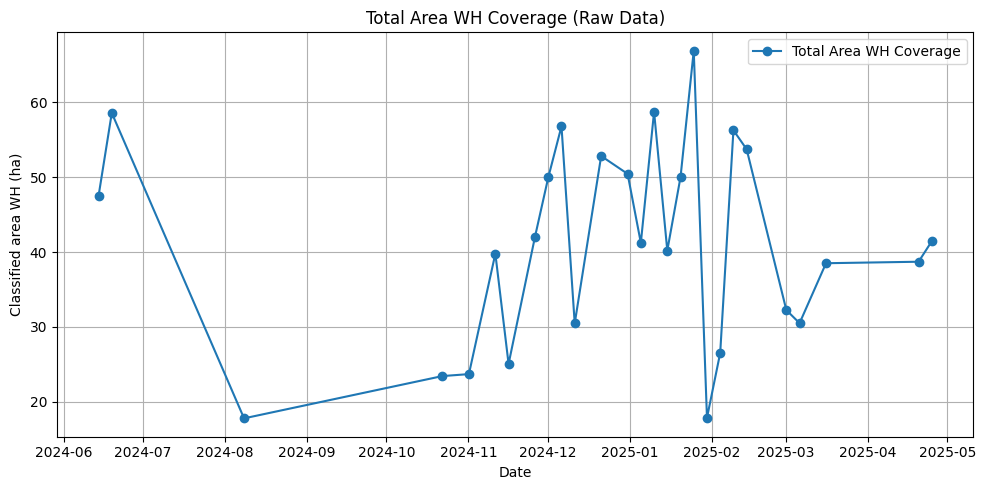

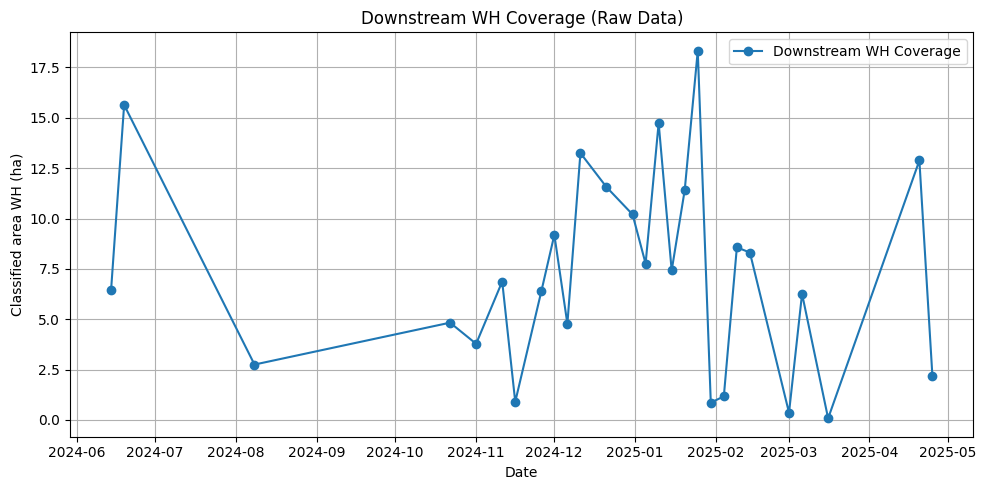

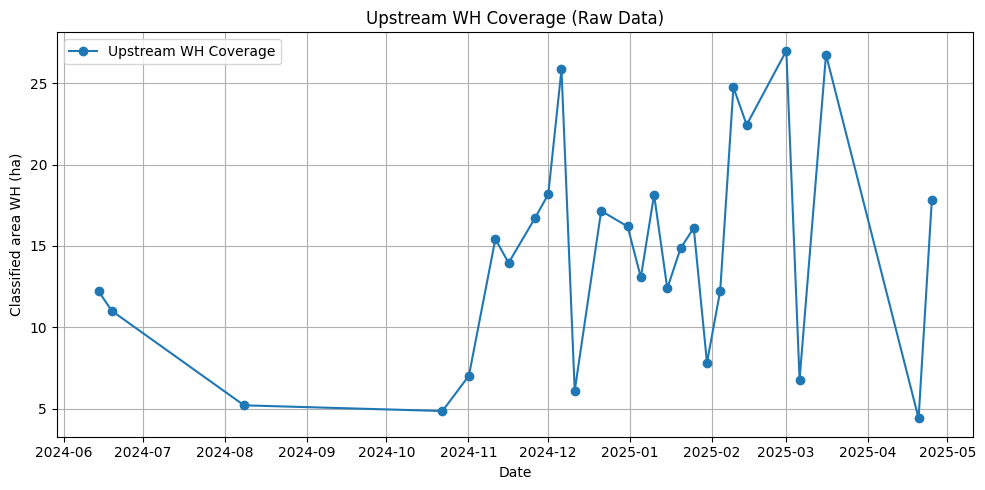

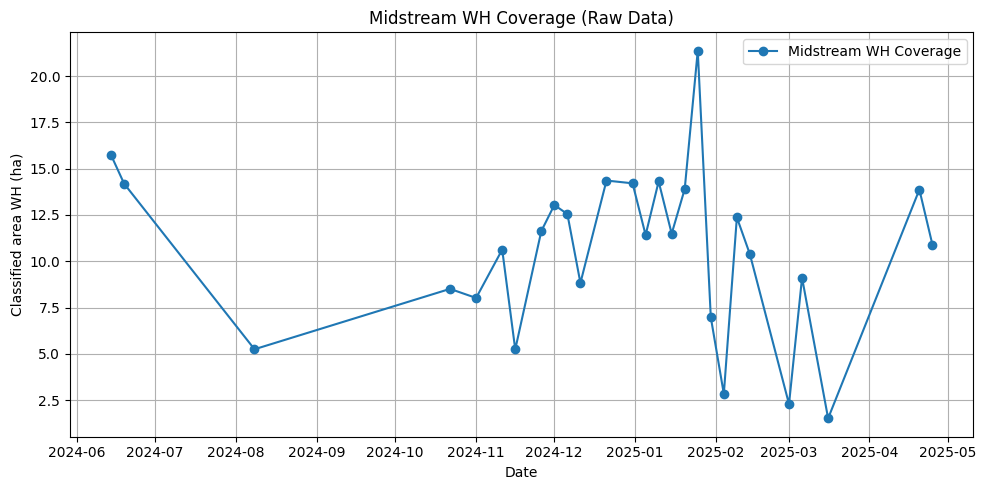

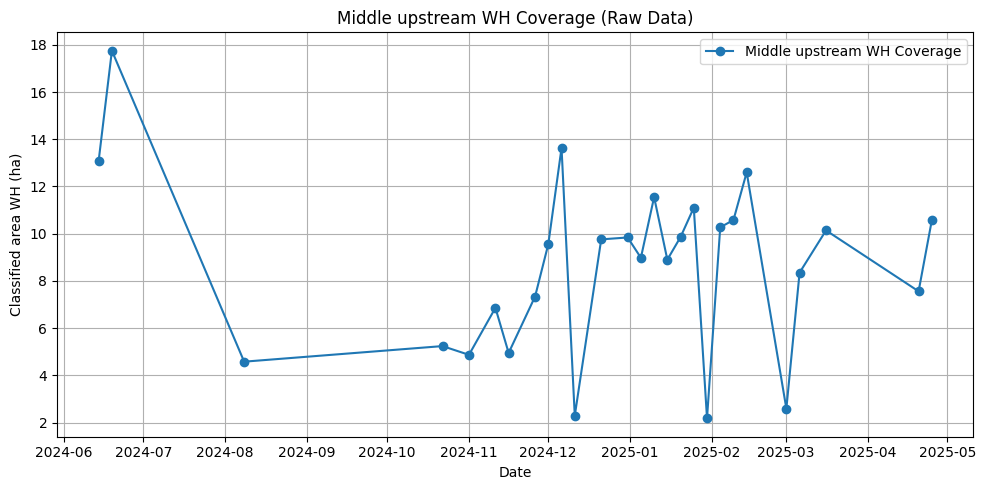

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# --- STEP 3: Format the Data Without Monthly Aggregation ---

def format_raw_data(times, areas):
    """Format raw data into a DataFrame without resampling."""
    df = pd.DataFrame({"date": times, "Classified area WH (ha)": areas})
    df["date"] = pd.to_datetime(df["date"])  # Ensure proper datetime format
    df.sort_values("date", inplace=True)
    return df

# Total area across all patches
df_total = format_raw_data(times_total, area_total)
df_downstream = format_raw_data(times_downstream, area_downstream)
df_upstream = format_raw_data(times_upstream, area_upstream)
df_mid_upstream = format_raw_data(times_mid_upstream, area_mid_upstream)
df_midstream = format_raw_data(times_midstream, area_midstream)

# --- STEP 4: Create and Save Separate CSV Files ---

def save_csv(df, output_path):
    """Save DataFrame to CSV."""
    if df is None or df.empty:
        print(f"No data to save for {output_path}")
        return
    df.to_csv(output_path, index=False)
    print(f"CSV saved to: {output_path}")

# Define output directory
output_dir = "./drive/My Drive/SentinelModel/datalists3/"
os.makedirs(output_dir, exist_ok=True)

# Save CSVs
save_csv(df_total, os.path.join(output_dir, "total_area_raw.csv"))
save_csv(df_downstream, os.path.join(output_dir, "downstream_area_raw.csv"))
save_csv(df_upstream, os.path.join(output_dir, "upstream_area_raw.csv"))
save_csv(df_midstream, os.path.join(output_dir, "midstream_area_raw.csv"))
save_csv(df_mid_upstream, os.path.join(output_dir, "mid_upstream_area_raw.csv"))

# --- STEP 5: Plotting Per-Date Trends (No Monthly Aggregation) ---

def plot_raw_trend(df, title):
    """Plot WH coverage as raw points by date."""
    plt.figure(figsize=(10, 5))
    plt.plot(df["date"], df["Classified area WH (ha)"], marker='o', linestyle='-', label=title)
    plt.xlabel('Date')
    plt.ylabel('Classified area WH (ha)')
    plt.title(title + " (Raw Data)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot each section
plot_raw_trend(df_total, 'Total Area WH Coverage')
plot_raw_trend(df_downstream, 'Downstream WH Coverage')
plot_raw_trend(df_upstream, 'Upstream WH Coverage')
plot_raw_trend(df_midstream, 'Midstream WH Coverage')
plot_raw_trend(df_mid_upstream, 'Middle upstream WH Coverage')


### 8.3 Plot mean WH coverage (ha) per section over a year

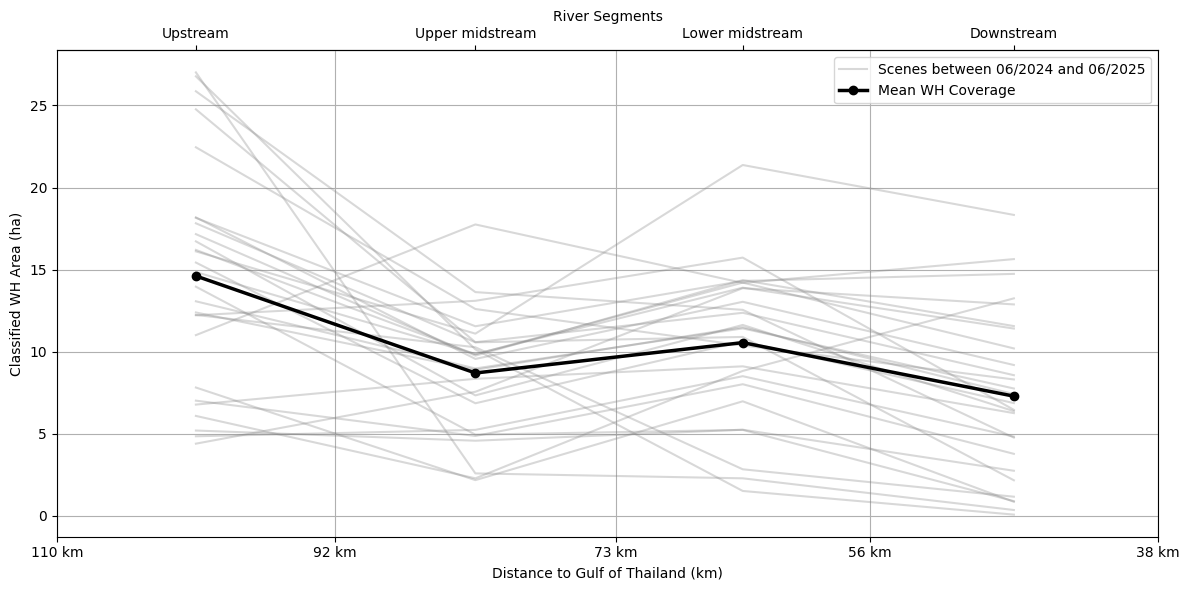

In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd

# 5 distance points = 4 segments
boundary_distances = [110.0, 91.7, 73.2, 56.5, 37.5]  # example boundary points (km)
segment_labels = ["Upstream", "Upper midstream", "Lower midstream", "Downstream"]

# Midpoints of segments = where you plot WH values
region_midpoints_km = [
    (boundary_distances[i] + boundary_distances[i + 1]) / 2
    for i in range(len(boundary_distances) - 1)
]

# Combine data into DataFrame
df_all = pd.DataFrame({
    "Upstream": df_upstream.set_index("date")["Classified area WH (ha)"],
    "Mid-Upstream": df_mid_upstream.set_index("date")["Classified area WH (ha)"],
    "Midstream": df_midstream.set_index("date")["Classified area WH (ha)"],
    "Downstream": df_downstream.set_index("date")["Classified area WH (ha)"],
})

df_all.dropna(inplace=True)

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 6))

# Plot individual dates
for i, date in enumerate(df_all.index):
    values = df_all.loc[date].values
    ax.plot(region_midpoints_km, values, color='gray', alpha=0.3, label="Scenes between 06/2024 and 06/2025" if i == 0 else "")

# Plot mean
mean_values = df_all.mean().values
ax.plot(region_midpoints_km, mean_values, marker='o', color='black', linewidth=2.5, label='Mean WH Coverage')

# Title and axis labels
start_date = df_all.index.min().strftime("%b %Y")
end_date = df_all.index.max().strftime("%b %Y")
ax.set_xlabel("Distance to Gulf of Thailand (km)")
ax.set_ylabel("Classified WH Area (ha)")
ax.grid(True)
ax.legend(loc="upper right")

# X-ticks: boundary distances
ax.set_xticks(boundary_distances)
ax.set_xticklabels([f"{d:.0f} km" for d in boundary_distances])
ax.invert_xaxis()  # Upstream on the left

# Add secondary axis for segment names (between ticks)
ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(region_midpoints_km)
ax2.set_xticklabels(segment_labels)
ax2.set_xlabel("River Segments")

# Save and show
output_path = "./drive/My Drive/SentinelModel/figures/Yearly_wh_absolute_coverage.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()



### 8.4 Plot WH coverage (ha) over time per section

/tmp/ipython-input-1897206697.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


Figure saved to: ./drive/My Drive/SentinelModel/figures/yearly_absolute_wh_coverage_vs_time.png


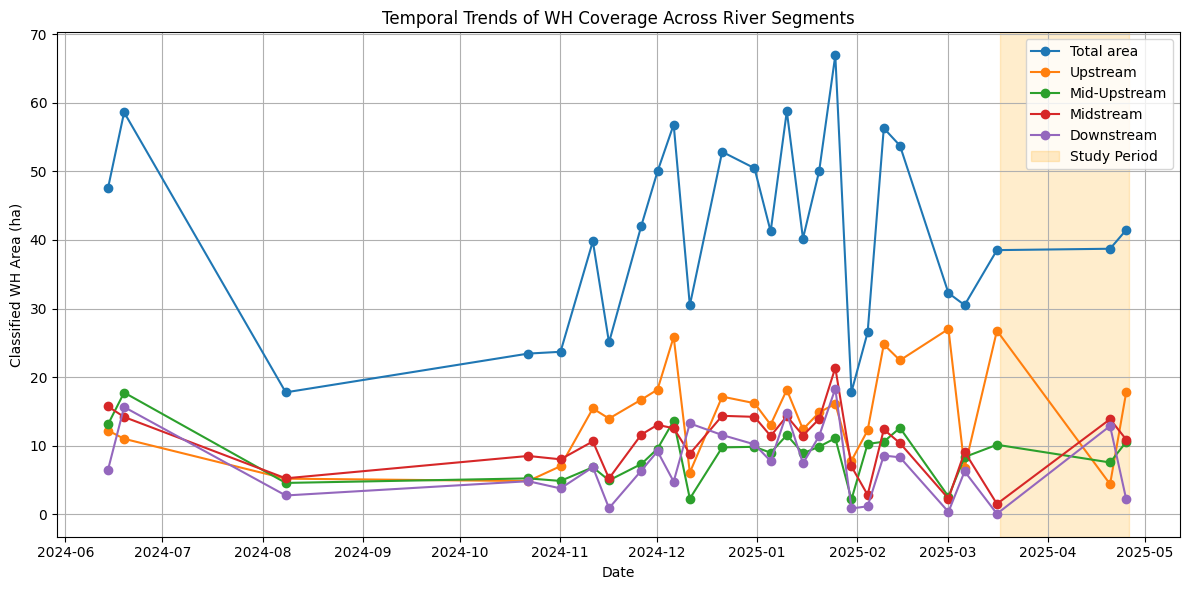

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- Build df_all from raw WH classified area (ha) ---
df_all = pd.DataFrame({
    "Total area": df_total.set_index("date")["Classified area WH (ha)"],
    "Upstream": df_upstream.set_index("date")["Classified area WH (ha)"],
    "Mid-Upstream": df_mid_upstream.set_index("date")["Classified area WH (ha)"],
    "Midstream": df_midstream.set_index("date")["Classified area WH (ha)"],
    "Downstream": df_downstream.set_index("date")["Classified area WH (ha)"]
}).sort_index()

# Create color map
colors = cm.get_cmap('tab10')

# Plot
plt.figure(figsize=(12, 6))

for i, col in enumerate(df_all.columns):
    plt.plot(df_all.index, df_all[col],
             marker='o', linestyle='-',
             label=col, color=colors(i))

# Highlight study period: 17 March to 26 April
start_study = pd.to_datetime("2025-03-17")
end_study = pd.to_datetime("2025-04-26")
plt.axvspan(start_study, end_study, color='orange', alpha=0.2, label="Study Period")

# Styling
plt.xlabel("Date")
plt.ylabel("Classified WH Area (ha)")
plt.title("Temporal Trends of WH Coverage Across River Segments")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save figure
output_path = "./drive/My Drive/SentinelModel/figures/yearly_absolute_wh_coverage_vs_time.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300)
print(f"Figure saved to: {output_path}")

plt.show()


## 9 Plot WH coverage results as percentage of total area


### 9.1 Plot WH percentage over distance, during a year per section

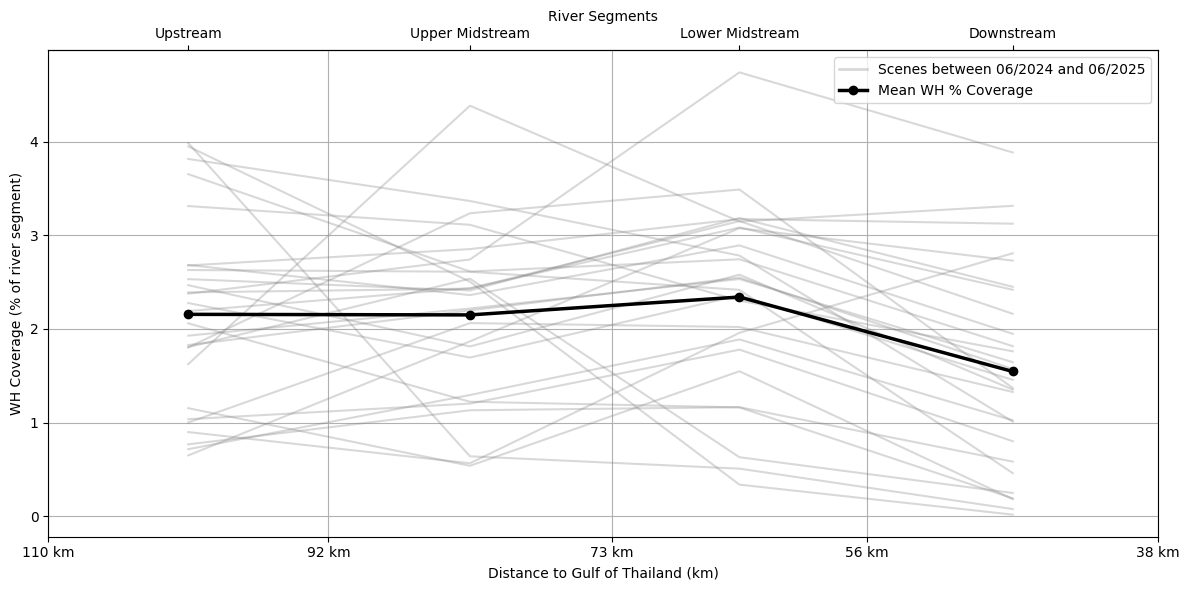

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
import os

# --- Define boundary distances and segment names ---
boundary_distances = [110.0, 91.7, 73.2, 56.5, 37.5]  # 5 distances = 4 segments
segment_labels = ["Upstream", "Upper Midstream", "Lower Midstream", "Downstream"]

# --- Segment midpoints for plotting WH coverage ---
region_midpoints_km = [
    (boundary_distances[i] + boundary_distances[i + 1]) / 2
    for i in range(len(boundary_distances) - 1)
]

# --- Segment areas (ha) for percentage conversion ---
segment_areas = {
    "Upstream": 678,
    "Mid-Upstream": 405,
    "Midstream": 451,
    "Downstream": 472
}

# --- Calculate percentage WH coverage ---
df_all = pd.DataFrame({
    "Upstream": df_upstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Upstream"] * 100,
    "Mid-Upstream": df_mid_upstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Mid-Upstream"] * 100,
    "Midstream": df_midstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Midstream"] * 100,
    "Downstream": df_downstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Downstream"] * 100,
})

df_all.dropna(inplace=True)

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each individual date (gray lines)
for i, date in enumerate(df_all.index):
    values = df_all.loc[date].values
    ax.plot(region_midpoints_km, values, color='gray', alpha=0.3)

# Plot mean WH % coverage (bold black line with dots)
mean_values = df_all.mean().values
ax.plot(region_midpoints_km, mean_values, marker='o', color='black', linewidth=2.5)

# --- Legend ---
legend_elements = [
    Line2D([0], [0], color='gray', alpha=0.3, linewidth=2, label='Scenes between 06/2024 and 06/2025'),
    Line2D([0], [0], color='black', marker='o', linewidth=2.5, label='Mean WH % Coverage')
]
ax.legend(handles=legend_elements, loc="upper right")

# --- Axis Labels & Grid ---
start = df_all.index.min().strftime('%b %Y')
end = df_all.index.max().strftime('%b %Y')
ax.set_xlabel("Distance to Gulf of Thailand (km)")
ax.set_ylabel("WH Coverage (% of river segment)")
ax.set_xticks(boundary_distances)
ax.set_xticklabels([f"{d:.0f} km" for d in boundary_distances])
ax.invert_xaxis()
ax.grid(True)

# --- Add segment names above axis ---
ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(region_midpoints_km)
ax2.set_xticklabels(segment_labels)
ax2.set_xlabel("River Segments")

plt.tight_layout()

# --- Save ---
output_path = "./drive/My Drive/SentinelModel/figures/yearly_WH_percentage_coverage.jpg"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300)
plt.show()


### 9.2 Plot WH percentage over distance, during the study period per section

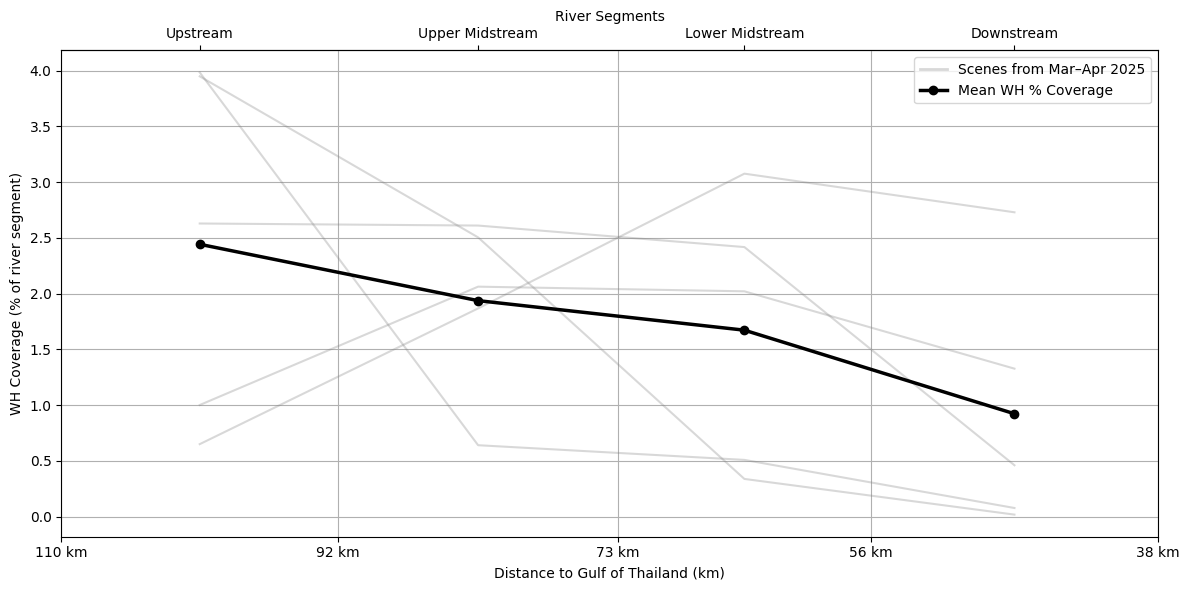

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
import os

# --- Define boundary distances and segment names ---
boundary_distances = [110.0, 91.7, 73.2, 56.5, 37.5]  # 5 distances = 4 segments
segment_labels = ["Upstream", "Upper Midstream", "Lower Midstream", "Downstream"]

# --- Segment midpoints for plotting WH coverage ---
region_midpoints_km = [
    (boundary_distances[i] + boundary_distances[i + 1]) / 2
    for i in range(len(boundary_distances) - 1)
]

# --- Segment areas (ha) for percentage conversion ---
segment_areas = {
    "Upstream": 678,
    "Mid-Upstream": 405,
    "Midstream": 451,
    "Downstream": 472
}

# --- Calculate percentage WH coverage ---
df_all = pd.DataFrame({
    "Upstream": df_upstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Upstream"] * 100,
    "Mid-Upstream": df_mid_upstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Mid-Upstream"] * 100,
    "Midstream": df_midstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Midstream"] * 100,
    "Downstream": df_downstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Downstream"] * 100,
})

# --- Filter for March and April 2025 ---
start = pd.to_datetime("2025-03-01")
end = pd.to_datetime("2025-05-01")
df_all = df_all[(df_all.index >= start) & (df_all.index <= end)]
df_all.dropna(inplace=True)

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each individual date (gray lines)
for i, date in enumerate(df_all.index):
    values = df_all.loc[date].values
    ax.plot(region_midpoints_km, values, color='gray', alpha=0.3)

# Plot mean WH % coverage (bold black line with dots)
mean_values = df_all.mean().values
ax.plot(region_midpoints_km, mean_values, marker='o', color='black', linewidth=2.5)

# --- Legend ---
legend_elements = [
    Line2D([0], [0], color='gray', alpha=0.3, linewidth=2, label='Scenes from Mar–Apr 2025'),
    Line2D([0], [0], color='black', marker='o', linewidth=2.5, label='Mean WH % Coverage')
]
ax.legend(handles=legend_elements, loc="upper right")

# --- Axis Labels & Grid ---
ax.set_xlabel("Distance to Gulf of Thailand (km)")
ax.set_ylabel("WH Coverage (% of river segment)")
ax.set_xticks(boundary_distances)
ax.set_xticklabels([f"{d:.0f} km" for d in boundary_distances])
ax.invert_xaxis()
ax.grid(True)

# --- Add segment names above axis ---
ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(region_midpoints_km)
ax2.set_xticklabels(segment_labels)
ax2.set_xlabel("River Segments")

plt.tight_layout()

# --- Save ---
output_path = "./drive/My Drive/SentinelModel/figures/WH_coverage_Mar_Apr_2025.jpg"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300)
plt.show()


### 9.3 Plot WH seasonality in percentage over a year per section

/tmp/ipython-input-4230491909.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


Figure saved to: ./drive/My Drive/SentinelModel/figures/yearly_wh_coverage_percentage_vs_time_no_title_article.pdf


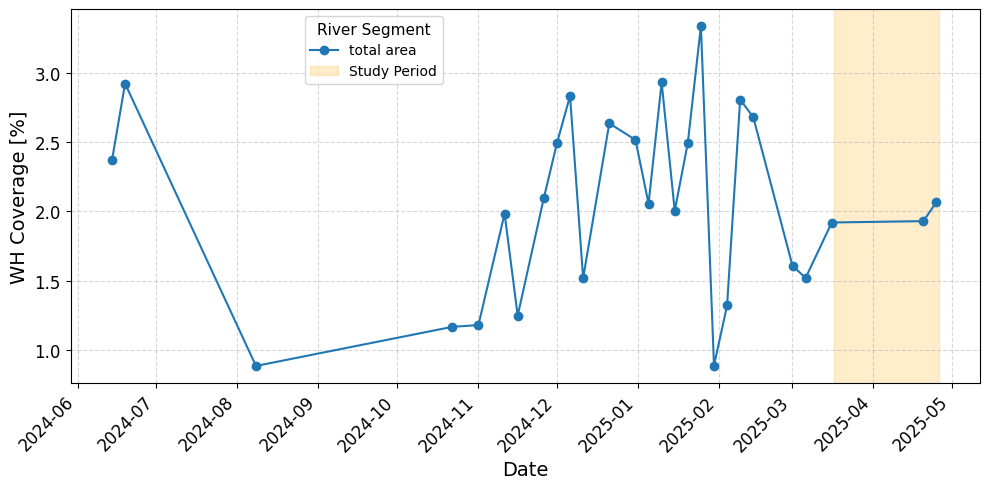

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

# Total segment areas in hectares
segment_areas = {
    "Total area": 2006,
    "Downstream": 472,
    "Mid-Upstream": 405,
    "Midstream": 451,
    "Upstream": 678
}

# --- Correct percentage WH coverage per segment ---
df_pct = pd.DataFrame({
    "total area": df_total.set_index("date")["Classified area WH (ha)"] / segment_areas["Total area"] * 100,
    # "Upstream": df_upstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Upstream"] * 100,
    # "Mid-Upstream": df_mid_upstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Mid-Upstream"] * 100,
    # "Midstream": df_midstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Midstream"] * 100,
    # "Downstream": df_downstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Downstream"] * 100,
}).sort_index()

# --- Plot ---
colors = cm.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(10, 5))

for i, col in enumerate(df_pct.columns):
    ax.plot(df_pct.index, df_pct[col],
             marker='o', linestyle='-',
             label=col, color=colors(i))

# Highlight study period
start_study = pd.to_datetime("2025-03-17")
end_study = pd.to_datetime("2025-04-26")
ax.axvspan(start_study, end_study, color='orange', alpha=0.2, label="Study Period")

# --- Styling ---
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("WH Coverage [%]", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(title="River Segment", fontsize=10, title_fontsize=11)
fig.autofmt_xdate(rotation=45)
ax.legend(title="River Segment", fontsize=10, title_fontsize=11, loc='upper left', bbox_to_anchor=(0.25, 1))


plt.tight_layout()

# --- Save figure ---
output_path = "./drive/My Drive/SentinelModel/figures/yearly_wh_coverage_percentage_vs_time_no_title_article.pdf"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300)
print(f"Figure saved to: {output_path}")

plt.show()


### 9.4 Retrieve summary of WH percentages

In [ ]:
# --- Compute total river WH coverage (% weighted by area) ---
weights = {
    seg: segment_areas[seg] / segment_areas["Total area"]
    for seg in ["Upstream", "Mid-Upstream", "Midstream", "Downstream"]
}
df_pct["Total River"] = sum(df_pct[seg] * weight for seg, weight in weights.items())

# --- Compute statistics ---
summary_stats = df_pct[["Upstream", "Mid-Upstream", "Midstream", "Downstream", "Total River"]].agg(["mean", "min", "max"])

# --- Display results ---
print("\n--- WH Coverage Summary Statistics [%] ---")
for stat in ["mean", "min", "max"]:
    print(f"\n{stat.capitalize()} WH coverage:")
    for segment in summary_stats.columns:
        value = summary_stats.loc[stat, segment]
        print(f"{segment}: {value:.2f}%")


KeyError: 'Upstream'

### 9.5 Plot WH seasonality in percentage over study period per section

/tmp/ipython-input-65580328.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


Figure saved to: ./drive/My Drive/SentinelModel/figures/wh_coverage_mar_apr_2025.png


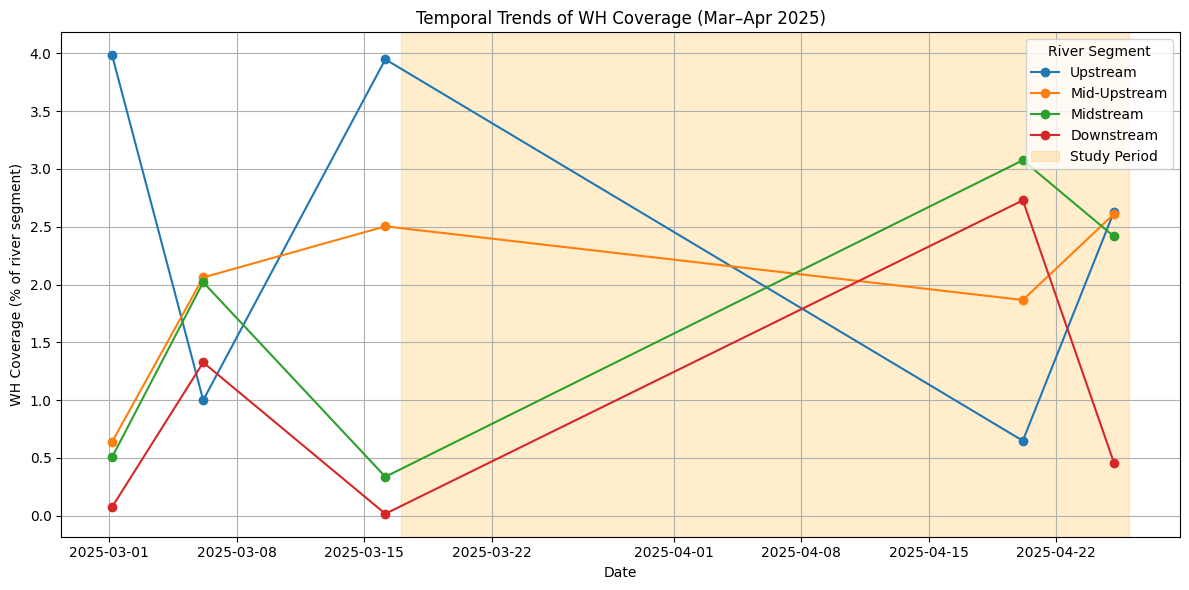

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

# Total segment areas in hectares
segment_areas = {
    "Downstream": 472,
    "Mid-Upstream": 405,
    "Midstream": 451,
    "Upstream": 678
}

# --- Compute WH coverage as percentage ---
df_pct = pd.DataFrame({
    "Upstream": df_upstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Upstream"] * 100,
    "Mid-Upstream": df_mid_upstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Mid-Upstream"] * 100,
    "Midstream": df_midstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Midstream"] * 100,
    "Downstream": df_downstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Downstream"] * 100,
}).sort_index()

# --- Filter for March and April 2025 ---
start = pd.to_datetime("2025-03-01")
end = pd.to_datetime("2025-04-30")
df_pct = df_pct[(df_pct.index >= start) & (df_pct.index <= end)]

# --- Plot ---
colors = cm.get_cmap('tab10')
plt.figure(figsize=(12, 6))

for i, col in enumerate(df_pct.columns):
    plt.plot(df_pct.index, df_pct[col],
             marker='o', linestyle='-',
             label=col, color=colors(i))

# Highlight study period: 17 March to 26 April
start_study = pd.to_datetime("2025-03-17")
end_study = pd.to_datetime("2025-04-26")
plt.axvspan(start_study, end_study, color='orange', alpha=0.2, label="Study Period")

# --- Styling ---
plt.xlabel("Date")
plt.ylabel("WH Coverage (% of river segment)")
plt.title("Temporal Trends of WH Coverage (Mar–Apr 2025)")
plt.grid(True)
plt.legend(title="River Segment")
plt.tight_layout()

# --- Save figure ---
output_path = "./drive/My Drive/SentinelModel/figures/wh_coverage_mar_apr_2025.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300)
print(f"Figure saved to: {output_path}")

plt.show()



## 10. Create main figures

### 10.1 Combine sentinel-2 with object-detection results

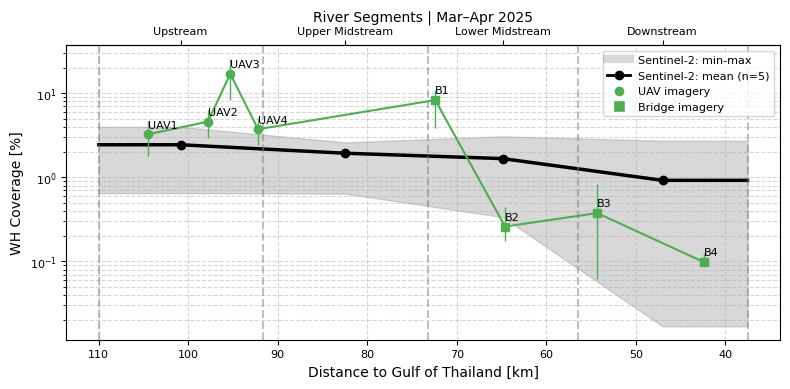

Figure saved to: ./drive/My Drive/SentinelModel/figures/wh_coverage_mar_apr_2025_all_methods_Article.pdf


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os

# --- Assume df_upstream, df_mid_upstream, df_midstream, df_downstream are already loaded with 'date' and 'Classified area WH (ha)' columns ---

boundary_distances = [110.0, 91.7, 73.2, 56.5, 37.5]
region_midpoints_km = [(boundary_distances[i] + boundary_distances[i + 1]) / 2 for i in range(len(boundary_distances) - 1)]
segment_labels = ["Upstream", "Upper Midstream", "Lower Midstream", "Downstream"]
segment_areas = {"Upstream": 678, "Mid-Upstream": 405, "Midstream": 451, "Downstream": 472}

# --- Calculate percentage WH coverage ---
df_all_timeseries = pd.DataFrame({
    "Upstream": df_upstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Upstream"] * 100,
    "Mid-Upstream": df_mid_upstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Mid-Upstream"] * 100,
    "Midstream": df_midstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Midstream"] * 100,
    "Downstream": df_downstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Downstream"] * 100,
})

# Filter March–April 2025
start = pd.to_datetime("2025-03-01")
end = pd.to_datetime("2025-05-01")
df_all_timeseries = df_all_timeseries[(df_all_timeseries.index >= start) & (df_all_timeseries.index <= end)]
df_all_timeseries.dropna(inplace=True)

# Compute mean, min, max
mean_values = df_all_timeseries.mean().values
min_values = df_all_timeseries.min().values
max_values = df_all_timeseries.max().values

# Extend to boundary points
extended_x = [boundary_distances[0]] + region_midpoints_km + [boundary_distances[-1]]
extended_y = [mean_values[0]] + list(mean_values) + [mean_values[-1]]
extended_min_y = [min_values[0]] + list(min_values) + [min_values[-1]]
extended_max_y = [max_values[0]] + list(max_values) + [max_values[-1]]

# --- UAV/Bridge data ---
uav_data = {
    'ID': ['UAV1', 'UAV2', 'UAV3', 'UAV4'],
    'WH_mean': [3.25391211, 4.590574549, 17.01936403, 3.736940129],
    'WH_min': [1.819529456, 2.899594125, 8.264613297, 2.426925629],
    'WH_max': [4.688294764, 6.281554972, 25.77411477, 5.046954628]
}

uav_df = pd.DataFrame(uav_data)
uav_df['Type'] = 'UAV imagery'

bridge_data = {
    'ID': ['B1', 'B2', 'B3', 'B4'],
    'WH_mean': [8.28907, 0.260304, 0.376089, 0.098669],
    'WH_min': [3.849058, 0.175941, 0.06173, 0.087226],
    'WH_max': [10.90691, 0.445814, 0.844407, 0.124957]
}
bridge_df = pd.DataFrame(bridge_data)
bridge_df['Type'] = 'Bridge imagery'

distances = pd.DataFrame({
    'ID': ['UAV1', 'UAV2', 'UAV3', 'UAV4', 'B1', 'B2', 'B3', 'B4'],
    'Distance': [104.5, 97.8, 95.3, 92.2, 72.4, 64.6, 54.3, 42.4]
})

df_all_uav_bridge = pd.concat([uav_df, bridge_df], ignore_index=True)
df_all_uav_bridge = df_all_uav_bridge.merge(distances, on='ID')
df_all_uav_bridge = df_all_uav_bridge.sort_values(by='Distance', ascending=False)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 4))

# Range band and mean line
ax.fill_between(extended_x, extended_min_y, extended_max_y, color='gray', alpha=0.3)
ax.plot(extended_x, extended_y, color='black', linewidth=2.5)
ax.plot(region_midpoints_km, mean_values, 'o', color='black')

# UAV/Bridge points
ax.plot(df_all_uav_bridge['Distance'], df_all_uav_bridge['WH_mean'], linestyle='-', color='#4CAF50', linewidth=1.5)
for i, row in df_all_uav_bridge.iterrows():
    ax.errorbar(row['Distance'], row['WH_mean'],
                yerr=[[row['WH_mean'] - row['WH_min']], [row['WH_max'] - row['WH_mean']]],
                fmt='o' if row['Type'] == 'UAV imagery' else 's',
                markersize=6, color='#4CAF50', ecolor='#4CAF50', elinewidth=1)
    ax.text(row['Distance'], row['WH_mean'] * 1.2, row['ID'], fontsize=8)

# Axes formatting
ax.set_xlabel('Distance to Gulf of Thailand [km]', fontsize=10)
ax.set_ylabel('WH Coverage [%]', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_yscale('log')
ax.invert_xaxis()
ax.grid(True, which='both', linestyle='--', alpha=0.5)

# Boundary lines
for bd in boundary_distances:
    ax.axvline(x=bd, color='gray', linestyle='--', alpha=0.5)

# Segment labels
ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(region_midpoints_km)
ax2.set_xticklabels(segment_labels, fontsize=8)
ax2.set_xlabel('River Segments | Mar–Apr 2025', fontsize=10)

# Legend
legend_elements = [
    Line2D([0], [0], color='gray', alpha=0.3, linewidth=6, label='Sentinel-2: min-max'),
    Line2D([0], [0], color='black', marker='o', linewidth=2, label='Sentinel-2: mean (n=5)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#4CAF50', markersize=8, label='UAV imagery'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#4CAF50', markersize=8, label='Bridge imagery')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

plt.tight_layout()

# Save figure
output_path = "./drive/My Drive/SentinelModel/figures/wh_coverage_mar_apr_2025_all_methods_Article.pdf"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300)
plt.show()
print(f"Figure saved to: {output_path}")


###10.2 Plot WH percentage over distance, during a year per section, revised

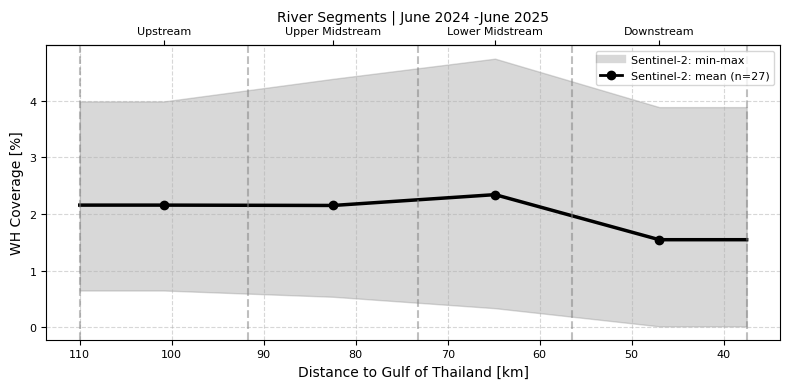

Number of gray lines plotted: 27


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
import os

# --- Define boundary distances and segment names ---
boundary_distances = [110.0, 91.7, 73.2, 56.5, 37.5]
segment_labels = ["Upstream", "Upper Midstream", "Lower Midstream", "Downstream"]
region_midpoints_km = [(boundary_distances[i] + boundary_distances[i + 1]) / 2 for i in range(len(boundary_distances) - 1)]
segment_areas = {"Upstream": 678, "Mid-Upstream": 405, "Midstream": 451, "Downstream": 472}

# --- Calculate percentage WH coverage ---
df_all = pd.DataFrame({
    "Upstream": df_upstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Upstream"] * 100,
    "Mid-Upstream": df_mid_upstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Mid-Upstream"] * 100,
    "Midstream": df_midstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Midstream"] * 100,
    "Downstream": df_downstream.set_index("date")["Classified area WH (ha)"] / segment_areas["Downstream"] * 100,
})
df_all.dropna(inplace=True)

# Compute mean, min, max
mean_values = df_all.mean().values
min_values = df_all.min().values
max_values = df_all.max().values

# Extend to boundaries
extended_x = [boundary_distances[0]] + region_midpoints_km + [boundary_distances[-1]]
extended_mean_y = [mean_values[0]] + list(mean_values) + [mean_values[-1]]
extended_min_y = [min_values[0]] + list(min_values) + [min_values[-1]]
extended_max_y = [max_values[0]] + list(max_values) + [max_values[-1]]

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 4))

# Fill range band
ax.fill_between(extended_x, extended_min_y, extended_max_y, color='gray', alpha=0.3, label='Range (Min-Max)')

# Plot mean WH % coverage (bold black line with dots)
ax.plot(extended_x, extended_mean_y, color='black', linewidth=2.5)
ax.plot(region_midpoints_km, mean_values, 'o', color='black')

# Axes formatting
ax.set_xlabel('Distance to Gulf of Thailand [km]', fontsize=10)
ax.set_ylabel('WH Coverage [%]', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.invert_xaxis()
ax.grid(True, which='both', linestyle='--', alpha=0.5)

# Boundary lines
for bd in boundary_distances:
    ax.axvline(x=bd, color='gray', linestyle='--', alpha=0.5)

# Segment labels
ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(region_midpoints_km)
ax2.set_xticklabels(segment_labels, fontsize=8)
ax2.set_xlabel('River Segments | June 2024 -June 2025', fontsize=10)

# Legend
legend_elements = [
    Line2D([0], [0], color='gray', alpha=0.3, linewidth=6, label='Sentinel-2: min-max'),
    Line2D([0], [0], color='black', marker='o', linewidth=2, label='Sentinel-2: mean (n=27)'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

plt.tight_layout()

# Save figure
output_path = "./drive/My Drive/SentinelModel/figures/yearly_WH_percentage_coverage_article.pdf"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300)
plt.show()

n = len(df_all.index)
print(f"Number of gray lines plotted: {n}")


##11 Perform statistical analyses

###11.1 Distance vs WH coverage (in study period)

In [ ]:
from scipy.stats import spearmanr

# Define distances from Gulf of Thailand for each segment midpoint (same order as df_all columns)
segment_distances = {
    "Upstream": region_midpoints_km[0],
    "Mid-Upstream": region_midpoints_km[1],
    "Midstream": region_midpoints_km[2],
    "Downstream": region_midpoints_km[3]
}

# Convert df_all (27 rows × 4 segments) into long format for correlation
df_long = df_all.reset_index().melt(id_vars="date", var_name="segment", value_name="wh_percent")
df_long["distance_km"] = df_long["segment"].map(segment_distances)

# Compute Spearman correlation across all 27 × 4 = 108 values
rho, pval = spearmanr(df_long["wh_percent"], df_long["distance_km"])

# Display results
print("\n--- Spearman Correlation ---")
print(f"ρ = {rho:.2f}, p = {pval:.4f}, n = {len(df_long)}")

# --- Compute mean, min, and max WH coverage per segment ---
coverage_stats = df_all.agg(["mean", "min", "max"]).round(2)

# --- Compute area-weighted total WH coverage (mean, min, max) ---
segment_areas_only = {
    "Upstream": 678,
    "Mid-Upstream": 405,
    "Midstream": 451,
    "Downstream": 472
}
total_area = sum(segment_areas_only.values())

# Create weights for each segment
weights = {seg: area / total_area for seg, area in segment_areas_only.items()}

# Compute weighted stats
weighted_mean = sum(df_all[seg].mean() * weights[seg] for seg in df_all.columns)
weighted_min = sum(df_all[seg].min() * weights[seg] for seg in df_all.columns)
weighted_max = sum(df_all[seg].max() * weights[seg] for seg in df_all.columns)

# --- Print results ---
print("\n--- WH Coverage Statistics [%] ---")
for stat in ["mean", "min", "max"]:
    print(f"\n{stat.capitalize()} WH coverage by segment:")
    for segment in df_all.columns:
        value = coverage_stats.loc[stat, segment]
        print(f"  {segment}: {value:.2f}%")

print(f"\nTotal River (area-weighted):")
print(f"  Mean: {weighted_mean:.2f}%")
print(f"  Min:  {weighted_min:.2f}%")
print(f"  Max:  {weighted_max:.2f}%")



--- Spearman Correlation ---
ρ = 0.46, p = 0.0425, n = 20

--- WH Coverage Statistics [%] ---

Mean WH coverage by segment:
  Upstream: 2.44%
  Mid-Upstream: 1.94%
  Midstream: 1.67%
  Downstream: 0.92%

Min WH coverage by segment:
  Upstream: 0.65%
  Mid-Upstream: 0.64%
  Midstream: 0.34%
  Downstream: 0.02%

Max WH coverage by segment:
  Upstream: 3.98%
  Mid-Upstream: 2.61%
  Midstream: 3.08%
  Downstream: 2.73%

Total River (area-weighted):
  Mean: 1.81%
  Min:  0.43%
  Max:  3.21%


### 11.2 Sentinel-2 vs Object detection (in study period)

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# --- 1. Sentinel-2 Segment Means ---
# Assumes df_all_timeseries is already filtered for Mar–Apr 2025

# Compute mean WH% per segment
sentinel_means = df_all_timeseries.mean().round(2).to_dict()
print("Sentinel WH% Means by Segment:", sentinel_means)

# Segment distances (midpoints)
sentinel_segment_distances = {
    "Upstream": 100.85,
    "Mid-Upstream": 82.45,
    "Midstream": 64.85,
    "Downstream": 47.0
}

# Segment areas (hectares)
segment_areas = {
    "Upstream": 678,
    "Mid-Upstream": 405,
    "Midstream": 451,
    "Downstream": 472
}

# Total area
total_area = sum(segment_areas.values())

# Build Sentinel dataframe
sentinel_df = pd.DataFrame({
    "Segment": sentinel_means.keys(),
    "WH_mean": sentinel_means.values()
})
sentinel_df["Distance"] = sentinel_df["Segment"].map(sentinel_segment_distances)
sentinel_df = sentinel_df.dropna().reset_index(drop=True).round(2)

print("\n✅ Sentinel data:")
print(sentinel_df)

# --- 2. UAV/Bridge Segment Assignment and Mean ---
df_all_uav_bridge['Segment'] = df_all_uav_bridge['ID'].map({
    'UAV1': 'Upstream', 'UAV2': 'Upstream', 'UAV3': 'Upstream', 'UAV4': 'Upstream',
    'B1': 'Midstream', 'B2': 'Midstream',
    'B3': 'Downstream', 'B4': 'Downstream'
})

# Group by segment
uav_bridge_segment_means = (
    df_all_uav_bridge
    .groupby('Segment')
    .agg({'WH_mean': 'mean', 'Distance': 'mean'})
    .reset_index()
    .round(2)
)

print("\n✅ UAV/Bridge data (grouped):")
print(uav_bridge_segment_means)

# --- 3. Spearman Correlations ---

# Sentinel WH_mean vs Distance
rho_sentinel, p_sentinel = spearmanr(sentinel_df['WH_mean'], sentinel_df['Distance'])

# UAV/Bridge WH_mean vs Distance
rho_uav, p_uav = spearmanr(uav_bridge_segment_means['WH_mean'], uav_bridge_segment_means['Distance'])

# Merge for cross-comparison (ignore Mid-Upstream if missing)
combined = pd.merge(
    sentinel_df,
    uav_bridge_segment_means,
    on='Segment',
    suffixes=('_sentinel', '_uav')
).dropna()

# Spearman: Sentinel vs UAV/Bridge WH_mean
rho_cross, p_cross = spearmanr(combined['WH_mean_sentinel'], combined['WH_mean_uav'])

# --- 4. Print Spearman Results ---
print("\n📌 Spearman Correlation Results:")
print(f"Sentinel WH_mean vs Distance:     ρ = {rho_sentinel:.2f}, p = {p_sentinel:.4f}")
print(f"UAV/Bridge WH_mean vs Distance:   ρ = {rho_uav:.2f}, p = {p_uav:.4f}")
print(f"Sentinel vs UAV/Bridge WH_mean:   ρ = {rho_cross:.2f}, p = {p_cross:.4f}")

# --- 5. UAV/Bridge Comparison to Sentinel Values ---
print("\n📊 Segment-Level UAV/Bridge Comparison:")

for segment in ['Upstream', 'Midstream', 'Downstream']:
    if segment in sentinel_means:
        ref = sentinel_means[segment]
        subset = df_all_uav_bridge[df_all_uav_bridge['Segment'] == segment]
        print(f"\nSentinel-2 {segment} Mean WH%: {ref:.2f}")
        for _, row in subset.iterrows():
            factor = row['WH_mean'] / ref if ref else None
            print(f"{row['ID']} mean WH% is {factor:.1f}x {'higher' if factor >= 1 else 'lower'} than Sentinel-2")

# --- 6. Total WH Area and Area-Weighted WH% ---
total_wh_area_ha = sum(
    sentinel_means[segment] / 100 * segment_areas[segment]
    for segment in sentinel_means
)

total_wh_pct = (total_wh_area_ha / total_area) * 100

print(f"\n📦 Overall average WH-covered area (ha): {total_wh_area_ha:.2f} ha")
print(f"📊 Overall average WH% across river (area-weighted): {total_wh_pct:.2f}%")


Sentinel WH% Means by Segment: {'Upstream': 2.44, 'Mid-Upstream': 1.94, 'Midstream': 1.67, 'Downstream': 0.92}

✅ Sentinel data:
        Segment  WH_mean  Distance
0      Upstream     2.44    100.85
1  Mid-Upstream     1.94     82.45
2     Midstream     1.67     64.85
3    Downstream     0.92     47.00

✅ UAV/Bridge data (grouped):
      Segment  WH_mean  Distance
0  Downstream     0.24     48.35
1   Midstream     4.27     68.50
2    Upstream     7.15     97.45

📌 Spearman Correlation Results:
Sentinel WH_mean vs Distance:     ρ = 1.00, p = 0.0000
UAV/Bridge WH_mean vs Distance:   ρ = 1.00, p = 0.0000
Sentinel vs UAV/Bridge WH_mean:   ρ = 1.00, p = 0.0000

📊 Segment-Level UAV/Bridge Comparison:

Sentinel-2 Upstream Mean WH%: 2.44
UAV1 mean WH% is 1.3x higher than Sentinel-2
UAV2 mean WH% is 1.9x higher than Sentinel-2
UAV3 mean WH% is 7.0x higher than Sentinel-2
UAV4 mean WH% is 1.5x higher than Sentinel-2

Sentinel-2 Midstream Mean WH%: 1.67
B1 mean WH% is 5.0x higher than Sentinel-2


### 11.3 Print values

In [ ]:
print("Sentinel values:")
print(sentinel_df)

print("\nUAV/Bridge values:")
print(uav_bridge_segment_means)

print("\nCombined for cross-correlation:")
print(combined[['Segment', 'WH_mean_sentinel', 'WH_mean_uav']])
print(df_all_uav_bridge[['ID', 'WH_mean', 'Distance']].sort_values(by='Distance', ascending=False))


Sentinel values:
        Segment  WH_mean  Distance
0      Upstream     2.44    100.85
1  Mid-Upstream     1.94     82.45
2     Midstream     1.67     64.85
3    Downstream     0.92     47.00

UAV/Bridge values:
      Segment  WH_mean  Distance
0  Downstream     0.24     48.35
1   Midstream     4.27     68.50
2    Upstream     7.15     97.45

Combined for cross-correlation:
      Segment  WH_mean_sentinel  WH_mean_uav
0    Upstream              2.44         7.15
1   Midstream              1.67         4.27
2  Downstream              0.92         0.24
     ID    WH_mean  Distance
0  UAV1   3.253912     104.5
1  UAV2   4.590575      97.8
2  UAV3  17.019364      95.3
3  UAV4   3.736940      92.2
4    B1   8.289070      72.4
5    B2   0.260304      64.6
6    B3   0.376089      54.3
7    B4   0.098669      42.4


### 11.4 Object detection vs Distance

In [ ]:
from scipy.stats import spearmanr

# Raw UAV/Bridge Spearman correlation (n = 8)
rho_raw, p_raw = spearmanr(df_all_uav_bridge['WH_mean'], df_all_uav_bridge['Distance'])

print(f"\n📌 Raw UAV/Bridge WH_mean vs Distance (n={len(df_all_uav_bridge)}):")
print(f"Spearman rho = {rho_raw:.2f}, p-value = {p_raw:.4f}")



📌 Raw UAV/Bridge WH_mean vs Distance (n=8):
Spearman rho = 0.62, p-value = 0.1017
